In [1]:
import os
import os.path
import sys
import math

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import keras
from keras import layers

Using TensorFlow backend.


In [4]:
sys.path.append(os.path.abspath('../dependencies/BristolStockExchange'))
sys.path.append(os.path.abspath('../src'))

# System setup

Model characteristics:
* Continuous inputs, discrete actions
* Discrete events in continuous time

### Flappy Bird

* State: (hight, lower border of the hole, upper border of the hole, time to hole)
* Actions: {fly up, keep falling}
* Reward: time survived

In [5]:
from reinforcement_example.game import Game

In [ ]:
# Play the game
game = Game()
while True:
    print(game.get_state())
    action = int(input())
    game.time_step(action)
    if not game.alive:
        print("DEAD!")
        break

In [6]:
from reinforcement_example.learner import make_model, make_model_elu

In [7]:
from reinforcement_example.learner import AbstractLearner

In [8]:
from reinforcement_example.learner import ScaledModel, ValueToPolicy

In [9]:
from reinforcement_trading.tools import logodds_to_probs, weights_to_inds, random_round

In [11]:
# class SoftPolicy(object):
#     def __init__(self, base, prob_random):
#         self.base = base
#         self.p = prob_random
        
#     def predict(self, states):
#         res = self.base.predict(states)
#         num_actions = res.shape[1]
#         uniform = np.ones(num_actions) / num_actions
#         res = self.p * uniform + (1 - self.p) * res
#         return res

In [11]:
class RandomPolicy(object):
    def __init__(self, numactions):
        self.numactions = numactions
    def predict(self, states):
        return np.zeros((len(states), self.numactions))
    def set_scale(self, scale):
        # Ignore
        pass

In [39]:
class TDLearner2(AbstractLearner):
    def __init__(self, state_dim, num_actions, reward_scale=1.0, model_factory=make_model_elu,
                 minimal_training_experience=200, episodes_between_trainings=50):
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.reward_scale = reward_scale
        self.model_factory = model_factory
        self.minimal_training_experience = minimal_training_experience
        self.episodes_between_trainings = episodes_between_trainings
        self.value_model = [ScaledModel(model_factory(state_dim, 1), yscale=reward_scale) for i in range(num_actions)]
        #self.policy = ValueToPolicy(self.value_model, scale=self.reward_scale)
        self.policy = RandomPolicy(self.num_actions)
        self.histories = []
        self.history = []
        # Helper arrays for faster training
        self.states = np.empty((0, self.state_dim))
        self.actions = np.empty(0, dtype=np.int)
        self.rewards = np.empty(0)
        self.logprobs = np.empty(0)
        self.ranges = np.empty((0, 2), dtype=np.int)
        self.actinds = [np.empty(0, dtype=np.int) for i in range(self.num_actions)]

    def move(self, state):
        probs = logodds_to_probs(self.policy.predict(state[np.newaxis, :])[0])
        choice = np.searchsorted(np.cumsum(probs), np.random.rand())
        self.last_action_prob = probs[choice]
        return choice
    
    def _state_value(self, state):
        action_values = np.array([model.predict(state[np.newaxis, :])[0, 0] for model in self.value_model])
        probs = logodds_to_probs(self.policy.predict(state[np.newaxis, :])[0, :])
        return np.dot(probs, action_values)

    def learn(self, state, action, reward, next_state, value_proxy):
        winds = [0] #weights_to_inds(np.array([self.last_action_prob]))
#         self.value_model[action].fit(state[np.newaxis, :][winds, :],
#                                      np.array([[reward + self._state_value(next_state)]])[winds],
#                                      verbose=False)
        self.history.append((np.array(state), action, reward, self.last_action_prob))

    def learn_last(self, state, action, reward):
        winds = [0] #weights_to_inds(np.array([self.last_action_prob]))
#         self.value_model[action].fit(state[np.newaxis, :][winds, :],
#                                      np.array([[reward]])[winds],
#                                      verbose=False)
        self.history.append((np.array(state), action, reward, self.last_action_prob))
        self.histories.append(self.history)
        self.history = []
        if len(self.histories) >= self.minimal_training_experience and \
           (len(self.histories) - self.minimal_training_experience) % self.episodes_between_trainings == 0:
            self._update_value_model()

    def _update_value_model(self):
        # Update data structures
        dsize = len(self.states)
        for i in range(len(self.ranges), len(self.histories)):
            last_states, last_actions, last_rewards, last_actionprob = zip(*self.histories[i][::-1])
            self.ranges = np.concatenate([self.ranges, np.array([[dsize, dsize + len(last_states)]])])
            dsize += len(last_states)
            self.states = np.concatenate([self.states, np.array(last_states)], axis=0)
            self.actions = np.concatenate([self.actions, np.array(last_actions, dtype=np.int)])
            self.rewards = np.concatenate([self.rewards, last_rewards])
            #self.logprobs = np.concatenate([self.logprobs, [0], np.log(last_actionprob)[:-1]])
            #self.actinds = [np.arange(len(self.actions))[self.actions == i] for i in range(self.num_actions)]
            self.actinds = [np.concatenate([self.actinds[i],
                                            np.arange(dsize - len(last_states), dsize)
                                                [self.actions[dsize - len(last_states):dsize] == i]])
                            for i in range(self.num_actions)]
        # Training
        policy_probs = logodds_to_probs(self.policy.predict(self.states))
        #policy_logprobs = np.log(policy_probs[np.arange(dsize), self.actions])
        #policy_cumlogprobs = np.zeros(dsize)
        #for start, end in self.ranges:
        #    policy_cumlogprobs[start + 1:end] = np.cumsum(policy_logprobs[start:end - 1])
        goon = True
        #last_prediction = None
        #while goon:
        model_factory = self.model_factory
        self.value_model = [ScaledModel(model_factory(self.state_dim, 1), yscale=self.reward_scale)
                            for i in range(self.num_actions)]
        for value_iter in range(300):
            predicted_state_action_value = np.array([model.predict(self.states)[:, 0] for model in self.value_model]).T
            predicted_state_value = np.sum(policy_probs * predicted_state_action_value, axis=1)
            response = np.empty(self.rewards.shape)
            response[:] = self.rewards
            for start, end in self.ranges:
                response[start + 1:end] += predicted_state_value[start:end - 1]
            predicted_value = predicted_state_action_value[np.arange(dsize), self.actions]
            # weights = np.exp(policy_logprobs - self.logprobs)
            for action in range(self.num_actions):
                inds = self.actinds[action]  #[weights_to_inds(weights[self.actinds[action]])]
                if len(inds) > 0:
                    self.value_model[action].fit(self.states[inds, :], response[inds],
                                                 epochs=10#,
                                                 #callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=10)]
                                                )
            ## What is eps?
            #if last_prediction is not None and
            #   np.max(np.abs(predicted_state_action_value - last_prediction)) < eps:
            #        goon = False
            #last_prediction = predicted_state_action_value
        # Policy scale
        self.policy = ValueToPolicy(self.value_model, scale=self.reward_scale)
        #mse = np.dot(weights, (predicted_value - response) ** 2) / np.sum(weights)
        #self.policy.set_scale(self.reward_scale / len(self.histories) + np.sqrt(mse))
        #self.policy.set_scale(self.reward_scale / np.sqrt(len(self.histories)))
        return


In [23]:
from reinforcement_example.learner import train_play

In [40]:
game = Game()
learner = TDLearner2(4, 2, reward_scale=game.mean_time_to_hole)

In [188]:
learner2 = TDLearner(4, 2, reward_scale=game.mean_time_to_hole)
learner2.histories = learner.histories
learner2.value_model = learner.value_model
learner2._update_value_model()
learner_bak = learner
learner = learner2


Epoch 1/10
29552/29552 [==============================] - 2s 71us/step - loss: 41.9196
Epoch 2/10
29552/29552 [==============================] - 2s 80us/step - loss: 41.0478
Epoch 3/10
29552/29552 [==============================] - 2s 77us/step - loss: 41.7494
Epoch 4/10
29552/29552 [==============================] - 2s 71us/step - loss: 42.0738
Epoch 1/10
35995/35995 [==============================] - 3s 78us/step - loss: 22.3180
Epoch 2/10
35995/35995 [==============================] - 3s 72us/step - loss: 22.4159
Epoch 3/10
35995/35995 [==============================] - 3s 74us/step - loss: 22.1707
Epoch 4/10
35995/35995 [==============================] - 3s 73us/step - loss: 22.7951
Epoch 5/10
35995/35995 [==============================] - 3s 76us/step - loss: 22.1064
Epoch 6/10
35995/35995 [==============================] - 3s 78us/step - loss: 22.5506
Epoch 7/10
35995/35995 [==============================] - 3s 72us/step - loss: 22.3347


In [15]:
for i in range(10):
    learner._update_value_model()

Epoch 1/10
17/17 [==============================] - 0s 120us/step - loss: 0.6948
Epoch 2/10
17/17 [==============================] - 0s 127us/step - loss: 0.6943
Epoch 3/10
17/17 [==============================] - 0s 239us/step - loss: 0.6937
Epoch 4/10
17/17 [==============================] - 0s 130us/step - loss: 0.6933
Epoch 5/10
17/17 [==============================] - 0s 140us/step - loss: 0.6928
Epoch 6/10
17/17 [==============================] - 0s 141us/step - loss: 0.6924
Epoch 7/10
17/17 [==============================] - 0s 173us/step - loss: 0.6920
Epoch 8/10
17/17 [==============================] - 0s 164us/step - loss: 0.6917
Epoch 9/10
17/17 [==============================] - 0s 137us/step - loss: 0.6913
Epoch 10/10
17/17 [==============================] - 0s 147us/step - loss: 0.6910
Epoch 1/10
9/9 [==============================] - 0s 282us/step - loss: 2.7371
Epoch 2/10
9/9 [==============================] - 0s 228us/step - loss: 2.4339
Epoch 3/10
9/9 [===============

Epoch 4/10
17/17 [==============================] - 0s 128us/step - loss: 0.2714
Epoch 5/10
17/17 [==============================] - 0s 124us/step - loss: 0.2714
Epoch 6/10
17/17 [==============================] - 0s 211us/step - loss: 0.2714
Epoch 7/10
17/17 [==============================] - 0s 152us/step - loss: 0.2714
Epoch 8/10
17/17 [==============================] - 0s 276us/step - loss: 0.2714
Epoch 9/10
17/17 [==============================] - 0s 218us/step - loss: 0.2714
Epoch 10/10
17/17 [==============================] - 0s 196us/step - loss: 0.2714
Epoch 1/10
9/9 [==============================] - 0s 568us/step - loss: 1.1078
Epoch 2/10
9/9 [==============================] - 0s 458us/step - loss: 1.1075
Epoch 3/10
9/9 [==============================] - 0s 279us/step - loss: 0.9776
Epoch 4/10
9/9 [==============================] - 0s 234us/step - loss: 0.9617
Epoch 5/10
9/9 [==============================] - 0s 209us/step - loss: 0.9005
Epoch 6/10
9/9 [=====================

In [15]:
def show_history(history):
    x = np.zeros(len(history))
    x[1:] = np.cumsum([info[2] for info in history[:-1]])
    y = np.array([info[0][0] for info in history])
    gates = dict()
    for i in range(len(history)):
        gx = x[i] + history[i][0][3]
        gl = history[i][0][1]
        gu = history[i][0][2]
        gates[np.round(gx)] = (gx, gl, gu)
    plt.plot(x, y, '-*')
    for gx, gl, gu in gates.values():
        plt.plot([gx, gx], [0, gl], 'r-')
        plt.plot([gx, gx], [gu, 100], 'r-')

58.54143222571392

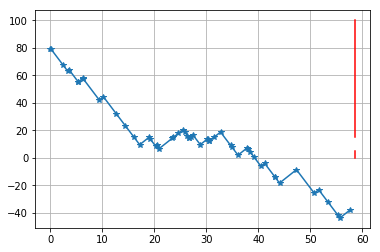

In [32]:
fooh, foor = train_play(Game(), learner)
show_history(fooh)
plt.grid(True)
foor

In [163]:
fooh[-1]

(array([53.92746374, 87.94064598, 88.2871137 ,  0.13904493]),
 1,
 0.13904492872458163)

In [41]:
history = []

100
Epoch 1/10
4333/4333 [==============================] - 0s 81us/step - loss: 0.4674
Epoch 2/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.1307
Epoch 3/10
4333/4333 [==============================] - 0s 64us/step - loss: 0.0765
Epoch 4/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0677
Epoch 5/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0663
Epoch 6/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0646
Epoch 7/10
4333/4333 [==============================] - 0s 80us/step - loss: 0.0636
Epoch 8/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0630
Epoch 9/10
4333/4333 [==============================] - 0s 58us/step - loss: 0.0618
Epoch 10/10
4333/4333 [==============================] - 0s 66us/step - loss: 0.0618
Epoch 1/10
4255/4255 [==============================] - 0s 85us/step - loss: 1.8150
Epoch 2/10
4255/4255 [==============================] - 0s 61us/step - 

4255/4255 [==============================] - 0s 61us/step - loss: 0.0095
Epoch 6/10
4255/4255 [==============================] - 0s 78us/step - loss: 0.0094
Epoch 7/10
4255/4255 [==============================] - 0s 67us/step - loss: 0.0095
Epoch 8/10
4255/4255 [==============================] - 0s 75us/step - loss: 0.0095
Epoch 9/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0091
Epoch 10/10
4255/4255 [==============================] - 0s 96us/step - loss: 0.0091
Epoch 1/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0092
Epoch 2/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0094
Epoch 3/10
4333/4333 [==============================] - 0s 100us/step - loss: 0.0091
Epoch 4/10
4333/4333 [==============================] - 0s 93us/step - loss: 0.0096
Epoch 5/10
4333/4333 [==============================] - 0s 71us/step - loss: 0.0095
Epoch 6/10
4333/4333 [==============================] - 0s 77us/step - loss: 0.0091
E

4333/4333 [==============================] - 0s 70us/step - loss: 0.0093
Epoch 10/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0092
Epoch 1/10
4255/4255 [==============================] - 0s 57us/step - loss: 0.0075
Epoch 2/10
4255/4255 [==============================] - 0s 62us/step - loss: 0.0072
Epoch 3/10
4255/4255 [==============================] - 0s 74us/step - loss: 0.0070
Epoch 4/10
4255/4255 [==============================] - 0s 62us/step - loss: 0.0071
Epoch 5/10
4255/4255 [==============================] - 0s 60us/step - loss: 0.0071
Epoch 6/10
4255/4255 [==============================] - 0s 55us/step - loss: 0.0072
Epoch 7/10
4255/4255 [==============================] - 0s 68us/step - loss: 0.0071
Epoch 8/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0072
Epoch 9/10
4255/4255 [==============================] - 0s 66us/step - loss: 0.0069
Epoch 10/10
4255/4255 [==============================] - 0s 69us/step - loss: 0.0070
E

4333/4333 [==============================] - 0s 58us/step - loss: 0.0085
Epoch 4/10
4333/4333 [==============================] - 0s 68us/step - loss: 0.0082
Epoch 5/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0081
Epoch 6/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0081
Epoch 7/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0086
Epoch 8/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0078
Epoch 9/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0079
Epoch 10/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0082
Epoch 1/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0058
Epoch 2/10
4255/4255 [==============================] - 0s 60us/step - loss: 0.0056
Epoch 3/10
4255/4255 [==============================] - 0s 56us/step - loss: 0.0056
Epoch 4/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0057
Ep

4255/4255 [==============================] - 0s 59us/step - loss: 0.0038
Epoch 8/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0037
Epoch 9/10
4255/4255 [==============================] - 0s 69us/step - loss: 0.0036
Epoch 10/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0035
Epoch 1/10
4333/4333 [==============================] - 0s 68us/step - loss: 0.0062
Epoch 2/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0058
Epoch 3/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0060
Epoch 4/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0059
Epoch 5/10
4333/4333 [==============================] - 0s 61us/step - loss: 0.0061
Epoch 6/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0060
Epoch 7/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0060
Epoch 8/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0060
Ep

4255/4255 [==============================] - 0s 68us/step - loss: 0.0036
Epoch 2/10
4255/4255 [==============================] - 0s 58us/step - loss: 0.0036
Epoch 3/10
4255/4255 [==============================] - 0s 76us/step - loss: 0.0035
Epoch 4/10
4255/4255 [==============================] - 0s 58us/step - loss: 0.0036
Epoch 5/10
4255/4255 [==============================] - 0s 60us/step - loss: 0.0035
Epoch 6/10
4255/4255 [==============================] - 0s 64us/step - loss: 0.0036
Epoch 7/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0035
Epoch 8/10
4255/4255 [==============================] - 0s 58us/step - loss: 0.0035
Epoch 9/10
4255/4255 [==============================] - 0s 57us/step - loss: 0.0036
Epoch 10/10
4255/4255 [==============================] - 0s 60us/step - loss: 0.0035
Epoch 1/10
4333/4333 [==============================] - 0s 58us/step - loss: 0.0053
Epoch 2/10
4333/4333 [==============================] - 0s 72us/step - loss: 0.0050
Ep

4333/4333 [==============================] - 0s 82us/step - loss: 0.0049
Epoch 6/10
4333/4333 [==============================] - 0s 85us/step - loss: 0.0048
Epoch 7/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0048
Epoch 8/10
4333/4333 [==============================] - 0s 65us/step - loss: 0.0049
Epoch 9/10
4333/4333 [==============================] - 0s 66us/step - loss: 0.0046
Epoch 10/10
4333/4333 [==============================] - 0s 61us/step - loss: 0.0048
Epoch 1/10
4255/4255 [==============================] - 0s 71us/step - loss: 0.0037
Epoch 2/10
4255/4255 [==============================] - 0s 85us/step - loss: 0.0038
Epoch 3/10
4255/4255 [==============================] - 0s 89us/step - loss: 0.0037
Epoch 4/10
4255/4255 [==============================] - 0s 85us/step - loss: 0.0037
Epoch 5/10
4255/4255 [==============================] - ETA: 0s - loss: 0.003 - 0s 97us/step - loss: 0.0037
Epoch 6/10
4255/4255 [==============================] - 0s 86u

4255/4255 [==============================] - 0s 92us/step - loss: 0.0042
Epoch 10/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0039
Epoch 1/10
4333/4333 [==============================] - 0s 63us/step - loss: 0.0051
Epoch 2/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0049
Epoch 3/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0053
Epoch 4/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0051
Epoch 5/10
4333/4333 [==============================] - 0s 100us/step - loss: 0.0052
Epoch 6/10
4333/4333 [==============================] - 0s 81us/step - loss: 0.0050
Epoch 7/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0049
Epoch 8/10
4333/4333 [==============================] - 0s 65us/step - loss: 0.0052
Epoch 9/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0050
Epoch 10/10
4333/4333 [==============================] - 0s 61us/step - loss: 0.0050


4255/4255 [==============================] - 0s 65us/step - loss: 0.0040
Epoch 4/10
4255/4255 [==============================] - 0s 56us/step - loss: 0.0039
Epoch 5/10
4255/4255 [==============================] - 0s 77us/step - loss: 0.0040
Epoch 6/10
4255/4255 [==============================] - 0s 79us/step - loss: 0.0039
Epoch 7/10
4255/4255 [==============================] - 0s 88us/step - loss: 0.0039
Epoch 8/10
4255/4255 [==============================] - 0s 56us/step - loss: 0.0041
Epoch 9/10
4255/4255 [==============================] - 0s 60us/step - loss: 0.0040
Epoch 10/10
4255/4255 [==============================] - 0s 70us/step - loss: 0.0038
Epoch 1/10
4333/4333 [==============================] - 0s 68us/step - loss: 0.0045
Epoch 2/10
4333/4333 [==============================] - 0s 93us/step - loss: 0.0042
Epoch 3/10
4333/4333 [==============================] - 0s 76us/step - loss: 0.0045
Epoch 4/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0043
Ep

4333/4333 [==============================] - 0s 87us/step - loss: 0.0039
Epoch 8/10
4333/4333 [==============================] - 0s 88us/step - loss: 0.0042
Epoch 9/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0039
Epoch 10/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0039
Epoch 1/10
4255/4255 [==============================] - 0s 59us/step - loss: 0.0038
Epoch 2/10
4255/4255 [==============================] - 0s 57us/step - loss: 0.0038
Epoch 3/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0037
Epoch 4/10
4255/4255 [==============================] - 0s 56us/step - loss: 0.0038
Epoch 5/10
4255/4255 [==============================] - 0s 59us/step - loss: 0.0037
Epoch 6/10
4255/4255 [==============================] - 0s 71us/step - loss: 0.0037
Epoch 7/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0037
Epoch 8/10
4255/4255 [==============================] - 0s 59us/step - loss: 0.0037
Ep

4333/4333 [==============================] - 0s 65us/step - loss: 0.0035
Epoch 2/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0039
Epoch 3/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0036
Epoch 4/10
4333/4333 [==============================] - 0s 64us/step - loss: 0.0036
Epoch 5/10
4333/4333 [==============================] - 0s 78us/step - loss: 0.0037
Epoch 6/10
4333/4333 [==============================] - 0s 89us/step - loss: 0.0035
Epoch 7/10
4333/4333 [==============================] - 0s 62us/step - loss: 0.0036
Epoch 8/10
4333/4333 [==============================] - 0s 65us/step - loss: 0.0036
Epoch 9/10
4333/4333 [==============================] - 0s 62us/step - loss: 0.0035
Epoch 10/10
4333/4333 [==============================] - 0s 60us/step - loss: 0.0037
Epoch 1/10
4255/4255 [==============================] - 0s 86us/step - loss: 0.0037
Epoch 2/10
4255/4255 [==============================] - 0s 92us/step - loss: 0.0035
Ep

4255/4255 [==============================] - 0s 57us/step - loss: 0.0034
Epoch 6/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0034
Epoch 7/10
4255/4255 [==============================] - 0s 59us/step - loss: 0.0035
Epoch 8/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0033
Epoch 9/10
4255/4255 [==============================] - 0s 56us/step - loss: 0.0033
Epoch 10/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0035
Epoch 1/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0034
Epoch 2/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0034
Epoch 3/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0034
Epoch 4/10
4333/4333 [==============================] - 0s 59us/step - loss: 0.0034
Epoch 5/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0033
Epoch 6/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0033
Ep

4333/4333 [==============================] - 0s 84us/step - loss: 0.0035
Epoch 10/10
4333/4333 [==============================] - 0s 84us/step - loss: 0.0033
Epoch 1/10
4255/4255 [==============================] - 0s 66us/step - loss: 0.0033
Epoch 2/10
4255/4255 [==============================] - 0s 67us/step - loss: 0.0033
Epoch 3/10
4255/4255 [==============================] - 0s 57us/step - loss: 0.0035
Epoch 4/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0032
Epoch 5/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0035
Epoch 6/10
4255/4255 [==============================] - 0s 65us/step - loss: 0.0033
Epoch 7/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0034
Epoch 8/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0034
Epoch 9/10
4255/4255 [==============================] - 0s 55us/step - loss: 0.0034
Epoch 10/10
4255/4255 [==============================] - 0s 70us/step - loss: 0.0032
E

4333/4333 [==============================] - 0s 59us/step - loss: 0.0031
Epoch 7/10
4333/4333 [==============================] - 0s 69us/step - loss: 0.0030
Epoch 8/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0031: 0s - loss: 0.
Epoch 9/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0030
Epoch 10/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0032
Epoch 1/10
4255/4255 [==============================] - 0s 59us/step - loss: 0.0031
Epoch 2/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0031
Epoch 3/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0031
Epoch 4/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0031
Epoch 5/10
4255/4255 [==============================] - 0s 72us/step - loss: 0.0031
Epoch 6/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0031
Epoch 7/10
4255/4255 [==============================] - 0s 53us/step - 

4333/4333 [==============================] - 0s 54us/step - loss: 0.0028
Epoch 4/10
4333/4333 [==============================] - 0s 59us/step - loss: 0.0027
Epoch 5/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0027
Epoch 6/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0028
Epoch 7/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0028
Epoch 8/10
4333/4333 [==============================] - 0s 73us/step - loss: 0.0027
Epoch 9/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0027
Epoch 10/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0028
Epoch 1/10
4255/4255 [==============================] - 0s 56us/step - loss: 0.0028
Epoch 2/10
4255/4255 [==============================] - 0s 62us/step - loss: 0.0028
Epoch 3/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0028
Epoch 4/10
4255/4255 [==============================] - 0s 56us/step - loss: 0.0028
Ep

4255/4255 [==============================] - 0s 69us/step - loss: 0.0024
Epoch 8/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0024
Epoch 9/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0025
Epoch 10/10
4255/4255 [==============================] - 0s 58us/step - loss: 0.0024
Epoch 1/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0023
Epoch 2/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0023
Epoch 3/10
4333/4333 [==============================] - 0s 72us/step - loss: 0.0023
Epoch 4/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0024
Epoch 5/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0024
Epoch 6/10
4333/4333 [==============================] - 0s 58us/step - loss: 0.0023
Epoch 7/10
4333/4333 [==============================] - 0s 58us/step - loss: 0.0022
Epoch 8/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0023
Ep

4255/4255 [==============================] - 0s 56us/step - loss: 0.0022
Epoch 2/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0021
Epoch 3/10
4255/4255 [==============================] - 0s 56us/step - loss: 0.0021
Epoch 4/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0022
Epoch 5/10
4255/4255 [==============================] - 0s 55us/step - loss: 0.0021
Epoch 6/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 7/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0021
Epoch 8/10
4255/4255 [==============================] - 0s 64us/step - loss: 0.0022
Epoch 9/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0021
Epoch 10/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0022
Epoch 1/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0022
Epoch 2/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0023
Ep

4333/4333 [==============================] - 0s 56us/step - loss: 0.0022
Epoch 6/10
4333/4333 [==============================] - 0s 60us/step - loss: 0.0022
Epoch 7/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0023
Epoch 8/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0021
Epoch 9/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0023
Epoch 10/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0022
Epoch 1/10
4255/4255 [==============================] - 0s 69us/step - loss: 0.0027
Epoch 2/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0027
Epoch 3/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0027
Epoch 4/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0027
Epoch 5/10
4255/4255 [==============================] - 0s 67us/step - loss: 0.0027
Epoch 6/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0028
Ep

4255/4255 [==============================] - 0s 60us/step - loss: 0.0022
Epoch 10/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0022
Epoch 1/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0023
Epoch 2/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0024
Epoch 3/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0023
Epoch 4/10
4333/4333 [==============================] - 0s 64us/step - loss: 0.0023
Epoch 5/10
4333/4333 [==============================] - 0s 63us/step - loss: 0.0023
Epoch 6/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0023
Epoch 7/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0023
Epoch 8/10
4333/4333 [==============================] - 0s 70us/step - loss: 0.0023
Epoch 9/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 10/10
4333/4333 [==============================] - 0s 57us/step - loss: 0.0023
E

4255/4255 [==============================] - 0s 51us/step - loss: 0.0023
Epoch 4/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0022
Epoch 5/10
4255/4255 [==============================] - 0s 55us/step - loss: 0.0022
Epoch 6/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0024
Epoch 7/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 8/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0023
Epoch 9/10
4255/4255 [==============================] - 0s 66us/step - loss: 0.0023
Epoch 10/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0022
Epoch 1/10
4333/4333 [==============================] - 0s 58us/step - loss: 0.0025
Epoch 2/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0025
Epoch 3/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0025
Epoch 4/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0026
Ep

4333/4333 [==============================] - 0s 58us/step - loss: 0.0023
Epoch 8/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0023
Epoch 9/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0023
Epoch 10/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0024
Epoch 1/10
4255/4255 [==============================] - 0s 66us/step - loss: 0.0023
Epoch 2/10
4255/4255 [==============================] - 0s 57us/step - loss: 0.0023
Epoch 3/10
4255/4255 [==============================] - 0s 49us/step - loss: 0.0023
Epoch 4/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0023
Epoch 5/10
4255/4255 [==============================] - 0s 68us/step - loss: 0.0023
Epoch 6/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0022
Epoch 7/10
4255/4255 [==============================] - 0s 47us/step - loss: 0.0023
Epoch 8/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0023
Ep

4333/4333 [==============================] - 0s 51us/step - loss: 0.0024
Epoch 2/10
4333/4333 [==============================] - 0s 65us/step - loss: 0.0024
Epoch 3/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0023
Epoch 4/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0023
Epoch 5/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 6/10
4333/4333 [==============================] - 0s 58us/step - loss: 0.0023
Epoch 7/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0023
Epoch 8/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0023
Epoch 9/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0023
Epoch 10/10
4333/4333 [==============================] - 0s 59us/step - loss: 0.0023
Epoch 1/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0023
Epoch 2/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0023
Ep

4255/4255 [==============================] - 0s 59us/step - loss: 0.0021
Epoch 6/10
4255/4255 [==============================] - 0s 68us/step - loss: 0.0020
Epoch 7/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 8/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0020
Epoch 9/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0020
Epoch 10/10
4255/4255 [==============================] - 0s 61us/step - loss: 0.0020
Epoch 1/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 2/10
4333/4333 [==============================] - 0s 70us/step - loss: 0.0021
Epoch 3/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0021
Epoch 4/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0019
Epoch 5/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 6/10
4333/4333 [==============================] - 0s 61us/step - loss: 0.0020
Ep

4333/4333 [==============================] - 0s 61us/step - loss: 0.0019
Epoch 10/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 1/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 2/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0019
Epoch 3/10
4255/4255 [==============================] - 0s 55us/step - loss: 0.0018
Epoch 4/10
4255/4255 [==============================] - 0s 62us/step - loss: 0.0019
Epoch 5/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 6/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 7/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 8/10
4255/4255 [==============================] - 0s 57us/step - loss: 0.0019
Epoch 9/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 10/10
4255/4255 [==============================] - 0s 48us/step - loss: 0.0019
E

4333/4333 [==============================] - 0s 54us/step - loss: 0.0017
Epoch 4/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 5/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0018
Epoch 6/10
4333/4333 [==============================] - 0s 68us/step - loss: 0.0017
Epoch 7/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0017
Epoch 8/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0017
Epoch 9/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0017
Epoch 10/10
4333/4333 [==============================] - 0s 62us/step - loss: 0.0017
Epoch 1/10
4255/4255 [==============================] - 0s 47us/step - loss: 0.0018
Epoch 2/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 3/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 4/10
4255/4255 [==============================] - 0s 64us/step - loss: 0.0018
Ep

4255/4255 [==============================] - 0s 60us/step - loss: 0.0016
Epoch 8/10
4255/4255 [==============================] - 0s 48us/step - loss: 0.0016
Epoch 9/10
4255/4255 [==============================] - 0s 64us/step - loss: 0.0016
Epoch 10/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 1/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0016
Epoch 2/10
4333/4333 [==============================] - 0s 49us/step - loss: 0.0016
Epoch 3/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 4/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 5/10
4333/4333 [==============================] - 0s 70us/step - loss: 0.0016
Epoch 6/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0017
Epoch 7/10
4333/4333 [==============================] - 0s 48us/step - loss: 0.0016
Epoch 8/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0017
Ep

4255/4255 [==============================] - 0s 58us/step - loss: 0.0017
Epoch 2/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 3/10
4255/4255 [==============================] - 0s 65us/step - loss: 0.0017
Epoch 4/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 5/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0017
Epoch 6/10
4255/4255 [==============================] - 0s 48us/step - loss: 0.0017
Epoch 7/10
4255/4255 [==============================] - 0s 61us/step - loss: 0.0018
Epoch 8/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0018
Epoch 9/10
4255/4255 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 10/10
4255/4255 [==============================] - 0s 48us/step - loss: 0.0017
Epoch 1/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0017
Epoch 2/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0017
Ep

4333/4333 [==============================] - 0s 58us/step - loss: 0.0017
Epoch 6/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0018
Epoch 7/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 8/10
4333/4333 [==============================] - 0s 60us/step - loss: 0.0017
Epoch 9/10
4333/4333 [==============================] - 0s 47us/step - loss: 0.0018
Epoch 10/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0018
Epoch 1/10
4255/4255 [==============================] - 0s 46us/step - loss: 0.0019
Epoch 2/10
4255/4255 [==============================] - 0s 57us/step - loss: 0.0018
Epoch 3/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0018
Epoch 4/10
4255/4255 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 5/10
4255/4255 [==============================] - 0s 48us/step - loss: 0.0019
Epoch 6/10
4255/4255 [==============================] - 0s 48us/step - loss: 0.0018
Ep

4255/4255 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 10/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0019
Epoch 1/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 2/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0016
Epoch 3/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 4/10
4333/4333 [==============================] - 0s 60us/step - loss: 0.0016
Epoch 5/10
4333/4333 [==============================] - 0s 60us/step - loss: 0.0015
Epoch 6/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0016
Epoch 7/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0016
Epoch 8/10
4333/4333 [==============================] - 0s 54us/step - loss: 0.0016
Epoch 9/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 10/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0016
E

4255/4255 [==============================] - 0s 67us/step - loss: 0.0022
Epoch 4/10
4255/4255 [==============================] - 0s 48us/step - loss: 0.0023
Epoch 5/10
4255/4255 [==============================] - 0s 48us/step - loss: 0.0022
Epoch 6/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 7/10
4255/4255 [==============================] - 0s 56us/step - loss: 0.0022
Epoch 8/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0022
Epoch 9/10
4255/4255 [==============================] - 0s 49us/step - loss: 0.0021
Epoch 10/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 1/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 2/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 3/10
4333/4333 [==============================] - 0s 49us/step - loss: 0.0016
Epoch 4/10
4333/4333 [==============================] - 0s 56us/step - loss: 0.0016
Ep

4333/4333 [==============================] - 0s 65us/step - loss: 0.0016
Epoch 8/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0016
Epoch 9/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 10/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0016
Epoch 1/10
4255/4255 [==============================] - 0s 61us/step - loss: 0.0027
Epoch 2/10
4255/4255 [==============================] - 0s 49us/step - loss: 0.0028
Epoch 3/10
4255/4255 [==============================] - 0s 53us/step - loss: 0.0028
Epoch 4/10
4255/4255 [==============================] - 0s 48us/step - loss: 0.0028
Epoch 5/10
4255/4255 [==============================] - 0s 50us/step - loss: 0.0029
Epoch 6/10
4255/4255 [==============================] - 0s 65us/step - loss: 0.0029
Epoch 7/10
4255/4255 [==============================] - 0s 49us/step - loss: 0.0027
Epoch 8/10
4255/4255 [==============================] - 0s 49us/step - loss: 0.0026
Ep

4333/4333 [==============================] - 0s 54us/step - loss: 0.0016
Epoch 2/10
4333/4333 [==============================] - 0s 62us/step - loss: 0.0016
Epoch 3/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0015
Epoch 4/10
4333/4333 [==============================] - 0s 53us/step - loss: 0.0016
Epoch 5/10
4333/4333 [==============================] - 0s 55us/step - loss: 0.0015
Epoch 6/10
4333/4333 [==============================] - 0s 59us/step - loss: 0.0016
Epoch 7/10
4333/4333 [==============================] - 0s 52us/step - loss: 0.0015
Epoch 8/10
4333/4333 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 9/10
4333/4333 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 10/10
4333/4333 [==============================] - 0s 67us/step - loss: 0.0016
Epoch 1/10
4255/4255 [==============================] - 0s 51us/step - loss: 0.0028
Epoch 2/10
4255/4255 [==============================] - 0s 46us/step - loss: 0.0028
Ep

5426/5426 [==============================] - 0s 58us/step - loss: 8.1663
Epoch 5/10
5426/5426 [==============================] - 0s 52us/step - loss: 8.1653
Epoch 6/10
5426/5426 [==============================] - 0s 50us/step - loss: 8.1119
Epoch 7/10
5426/5426 [==============================] - 0s 50us/step - loss: 7.9859
Epoch 8/10
5426/5426 [==============================] - 0s 62us/step - loss: 7.9744
Epoch 9/10
5426/5426 [==============================] - 0s 50us/step - loss: 7.9062
Epoch 10/10
5426/5426 [==============================] - 0s 53us/step - loss: 7.8083
Epoch 1/10
5465/5465 [==============================] - 0s 52us/step - loss: 62.5188
Epoch 2/10
5465/5465 [==============================] - 0s 49us/step - loss: 58.1675
Epoch 3/10
5465/5465 [==============================] - 0s 72us/step - loss: 54.0562
Epoch 4/10
5465/5465 [==============================] - 0s 52us/step - loss: 50.1788
Epoch 5/10
5465/5465 [==============================] - 0s 53us/step - loss: 46.45

5465/5465 [==============================] - 0s 53us/step - loss: 0.5138
Epoch 9/10
5465/5465 [==============================] - 0s 47us/step - loss: 0.4840
Epoch 10/10
5465/5465 [==============================] - 0s 55us/step - loss: 0.5232
Epoch 1/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.3985
Epoch 2/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.3865
Epoch 3/10
5426/5426 [==============================] - 0s 53us/step - loss: 0.3801
Epoch 4/10
5426/5426 [==============================] - 0s 60us/step - loss: 0.3810
Epoch 5/10
5426/5426 [==============================] - 0s 47us/step - loss: 0.3713
Epoch 6/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.3668
Epoch 7/10
5426/5426 [==============================] - 0s 56us/step - loss: 0.3680
Epoch 8/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.3652
Epoch 9/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.3679
Ep

5465/5465 [==============================] - 0s 55us/step - loss: 0.2351
Epoch 3/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.2254
Epoch 4/10
5465/5465 [==============================] - 0s 64us/step - loss: 0.2268
Epoch 5/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.2224
Epoch 6/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.2229
Epoch 7/10
5465/5465 [==============================] - 0s 58us/step - loss: 0.2191
Epoch 8/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.2132
Epoch 9/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.2199
Epoch 10/10
5465/5465 [==============================] - 0s 60us/step - loss: 0.2064
Epoch 1/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.2261
Epoch 2/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.2314
Epoch 3/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.2229
Ep

5426/5426 [==============================] - 0s 55us/step - loss: 0.1521
Epoch 7/10
5426/5426 [==============================] - 0s 56us/step - loss: 0.1529
Epoch 8/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.1579
Epoch 9/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.1503
Epoch 10/10
5426/5426 [==============================] - 0s 65us/step - loss: 0.1554
Epoch 1/10
5465/5465 [==============================] - 0s 59us/step - loss: 0.1267
Epoch 2/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.1285
Epoch 3/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.1270
Epoch 4/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.1240
Epoch 5/10
5465/5465 [==============================] - 0s 64us/step - loss: 0.1244
Epoch 6/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.1221
Epoch 7/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.1276
Ep

5465/5465 [==============================] - 0s 60us/step - loss: 0.0887
Epoch 1/10
5426/5426 [==============================] - 0s 45us/step - loss: 0.0989
Epoch 2/10
5426/5426 [==============================] - 0s 58us/step - loss: 0.0978
Epoch 3/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0983
Epoch 4/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0960
Epoch 5/10
5426/5426 [==============================] - 0s 47us/step - loss: 0.0972
Epoch 6/10
5426/5426 [==============================] - 0s 65us/step - loss: 0.0960
Epoch 7/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0977
Epoch 8/10
5426/5426 [==============================] - 0s 54us/step - loss: 0.0971
Epoch 9/10
5426/5426 [==============================] - 0s 58us/step - loss: 0.0952
Epoch 10/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0959
Epoch 1/10
5465/5465 [==============================] - 0s 69us/step - loss: 0.0868
Ep

5465/5465 [==============================] - 0s 64us/step - loss: 0.0555
Epoch 5/10
5465/5465 [==============================] - 0s 48us/step - loss: 0.0572
Epoch 6/10
5465/5465 [==============================] - 0s 48us/step - loss: 0.0563
Epoch 7/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0562
Epoch 8/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0563
Epoch 9/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0562
Epoch 10/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0566
Epoch 1/10
5426/5426 [==============================] - 0s 62us/step - loss: 0.0691
Epoch 2/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0697
Epoch 3/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0702
Epoch 4/10
5426/5426 [==============================] - 0s 55us/step - loss: 0.0697
Epoch 5/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0686
Ep

5426/5426 [==============================] - 0s 52us/step - loss: 0.0459
Epoch 9/10
5426/5426 [==============================] - 0s 59us/step - loss: 0.0458
Epoch 10/10
5426/5426 [==============================] - 0s 54us/step - loss: 0.0459
Epoch 1/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0376
Epoch 2/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0381
Epoch 3/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0378
Epoch 4/10
5465/5465 [==============================] - 0s 56us/step - loss: 0.0380
Epoch 5/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0369
Epoch 6/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0380
Epoch 7/10
5465/5465 [==============================] - 0s 63us/step - loss: 0.0378
Epoch 8/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0379
Epoch 9/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0379
Ep

5426/5426 [==============================] - 0s 53us/step - loss: 0.0339
Epoch 3/10
5426/5426 [==============================] - 0s 55us/step - loss: 0.0335
Epoch 4/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0339
Epoch 5/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0339
Epoch 6/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0334
Epoch 7/10
5426/5426 [==============================] - 0s 69us/step - loss: 0.0333
Epoch 8/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0341
Epoch 9/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.0331
Epoch 10/10
5426/5426 [==============================] - 0s 54us/step - loss: 0.0336
Epoch 1/10
5465/5465 [==============================] - 0s 62us/step - loss: 0.0269
Epoch 2/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0264
Epoch 3/10
5465/5465 [==============================] - 0s 54us/step - loss: 0.0277
Ep

5465/5465 [==============================] - 0s 52us/step - loss: 0.0219
Epoch 10/10
5465/5465 [==============================] - 0s 65us/step - loss: 0.0224
Epoch 1/10
5426/5426 [==============================] - 0s 57us/step - loss: 0.0273
Epoch 2/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0267
Epoch 3/10
5426/5426 [==============================] - 0s 56us/step - loss: 0.0269
Epoch 4/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0269
Epoch 5/10
5426/5426 [==============================] - 0s 53us/step - loss: 0.0268
Epoch 6/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0269
Epoch 7/10
5426/5426 [==============================] - 0s 63us/step - loss: 0.0272
Epoch 8/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0271
Epoch 9/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0267
Epoch 10/10
5426/5426 [==============================] - 0s 59us/step - loss: 0.0267
E

5465/5465 [==============================] - 0s 51us/step - loss: 0.0152
Epoch 4/10
5465/5465 [==============================] - 0s 48us/step - loss: 0.0150
Epoch 5/10
5465/5465 [==============================] - 0s 63us/step - loss: 0.0146
Epoch 6/10
5465/5465 [==============================] - 0s 54us/step - loss: 0.0153
Epoch 7/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0143
Epoch 8/10
5465/5465 [==============================] - 0s 61us/step - loss: 0.0146
Epoch 9/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0144
Epoch 10/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0146
Epoch 1/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0186
Epoch 2/10
5426/5426 [==============================] - 0s 61us/step - loss: 0.0188
Epoch 3/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0188
Epoch 4/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0186
Ep

5426/5426 [==============================] - 0s 59us/step - loss: 0.0156
Epoch 8/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0160
Epoch 9/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0156
Epoch 10/10
5426/5426 [==============================] - 0s 55us/step - loss: 0.0158
Epoch 1/10
5465/5465 [==============================] - 0s 54us/step - loss: 0.0093
Epoch 2/10
5465/5465 [==============================] - 0s 58us/step - loss: 0.0096
Epoch 3/10
5465/5465 [==============================] - 0s 42us/step - loss: 0.0091
Epoch 4/10
5465/5465 [==============================] - 0s 48us/step - loss: 0.0092
Epoch 5/10
5465/5465 [==============================] - 0s 78us/step - loss: 0.0094
Epoch 6/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0093
Epoch 7/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0093
Epoch 8/10
5465/5465 [==============================] - 0s 56us/step - loss: 0.0092
Ep

5426/5426 [==============================] - 0s 55us/step - loss: 0.0167
Epoch 2/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0166
Epoch 3/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0165
Epoch 4/10
5426/5426 [==============================] - 0s 59us/step - loss: 0.0166
Epoch 5/10
5426/5426 [==============================] - 0s 60us/step - loss: 0.0167
Epoch 6/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0166
Epoch 7/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0165
Epoch 8/10
5426/5426 [==============================] - 0s 56us/step - loss: 0.0166
Epoch 9/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0166
Epoch 10/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0166
Epoch 1/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0067
Epoch 2/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0067
Ep

5465/5465 [==============================] - 0s 50us/step - loss: 0.0062
Epoch 6/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0063
Epoch 7/10
5465/5465 [==============================] - 0s 58us/step - loss: 0.0062
Epoch 8/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0062
Epoch 9/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0062
Epoch 10/10
5465/5465 [==============================] - 0s 61us/step - loss: 0.0062
Epoch 1/10
5426/5426 [==============================] - 0s 54us/step - loss: 0.0193
Epoch 2/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.0192
Epoch 3/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0192
Epoch 4/10
5426/5426 [==============================] - 0s 56us/step - loss: 0.0191
Epoch 5/10
5426/5426 [==============================] - 0s 54us/step - loss: 0.0193
Epoch 6/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0192
Ep

5426/5426 [==============================] - 0s 51us/step - loss: 0.0230
Epoch 10/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0230
Epoch 1/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0066
Epoch 2/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0065
Epoch 3/10
5465/5465 [==============================] - 0s 59us/step - loss: 0.0066
Epoch 4/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0066
Epoch 5/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0067
Epoch 6/10
5465/5465 [==============================] - 0s 54us/step - loss: 0.0066
Epoch 7/10
5465/5465 [==============================] - 0s 62us/step - loss: 0.0065
Epoch 8/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0066
Epoch 9/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0066
Epoch 10/10
5465/5465 [==============================] - 0s 62us/step - loss: 0.0067
E

5426/5426 [==============================] - 0s 55us/step - loss: 0.0220
Epoch 4/10
5426/5426 [==============================] - 0s 46us/step - loss: 0.0221
Epoch 5/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0220
Epoch 6/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0219
Epoch 7/10
5426/5426 [==============================] - 0s 62us/step - loss: 0.0219
Epoch 8/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0220
Epoch 9/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0219
Epoch 10/10
5426/5426 [==============================] - 0s 57us/step - loss: 0.0220
Epoch 1/10
5465/5465 [==============================] - 0s 64us/step - loss: 0.0074
Epoch 2/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0076
Epoch 3/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0074
Epoch 4/10
5465/5465 [==============================] - 0s 55us/step - loss: 0.0074
Ep

5465/5465 [==============================] - 0s 51us/step - loss: 0.0065
Epoch 8/10
5465/5465 [==============================] - 0s 58us/step - loss: 0.0066
Epoch 9/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0064
Epoch 10/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0067
Epoch 1/10
5426/5426 [==============================] - 0s 62us/step - loss: 0.0241
Epoch 2/10
5426/5426 [==============================] - 0s 56us/step - loss: 0.0241
Epoch 3/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0241
Epoch 4/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.0241
Epoch 5/10
5426/5426 [==============================] - 0s 55us/step - loss: 0.0239
Epoch 6/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0241
Epoch 7/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0239
Epoch 8/10
5426/5426 [==============================] - 0s 63us/step - loss: 0.0239
Ep

5465/5465 [==============================] - 0s 61us/step - loss: 0.0047
Epoch 2/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0044
Epoch 3/10
5465/5465 [==============================] - 0s 57us/step - loss: 0.0045
Epoch 4/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0044
Epoch 5/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0044
Epoch 6/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0044
Epoch 7/10
5465/5465 [==============================] - 0s 68us/step - loss: 0.0045
Epoch 8/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0043
Epoch 9/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0045
Epoch 10/10
5465/5465 [==============================] - 0s 58us/step - loss: 0.0044
Epoch 1/10
5426/5426 [==============================] - 0s 54us/step - loss: 0.0103
Epoch 2/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0099
Ep

5426/5426 [==============================] - 0s 54us/step - loss: 0.0052
Epoch 6/10
5426/5426 [==============================] - 0s 53us/step - loss: 0.0054
Epoch 7/10
5426/5426 [==============================] - 0s 60us/step - loss: 0.0052
Epoch 8/10
5426/5426 [==============================] - 0s 60us/step - loss: 0.0052
Epoch 9/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0051
Epoch 10/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0052
Epoch 1/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0039
Epoch 2/10
5465/5465 [==============================] - 0s 65us/step - loss: 0.0039
Epoch 3/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0037
Epoch 4/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0037
Epoch 5/10
5465/5465 [==============================] - 0s 62us/step - loss: 0.0037
Epoch 6/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0038
Ep

5465/5465 [==============================] - 0s 52us/step - loss: 0.0040
Epoch 10/10
5465/5465 [==============================] - 0s 56us/step - loss: 0.0040
Epoch 1/10
5426/5426 [==============================] - 0s 53us/step - loss: 0.0048
Epoch 2/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0048
Epoch 3/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.0048
Epoch 4/10
5426/5426 [==============================] - 0s 54us/step - loss: 0.0047
Epoch 5/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.0047
Epoch 6/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0047
Epoch 7/10
5426/5426 [==============================] - 0s 59us/step - loss: 0.0046
Epoch 8/10
5426/5426 [==============================] - 0s 55us/step - loss: 0.0047
Epoch 9/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0047
Epoch 10/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0047
E

5465/5465 [==============================] - 0s 63us/step - loss: 0.0036
Epoch 4/10
5465/5465 [==============================] - 0s 55us/step - loss: 0.0036
Epoch 5/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0036
Epoch 6/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0035
Epoch 7/10
5465/5465 [==============================] - 0s 62us/step - loss: 0.0036
Epoch 8/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0036
Epoch 9/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0035
Epoch 10/10
5465/5465 [==============================] - 0s 60us/step - loss: 0.0036
Epoch 1/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0037
Epoch 2/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0036
Epoch 3/10
5426/5426 [==============================] - 0s 57us/step - loss: 0.0037
Epoch 4/10
5426/5426 [==============================] - 0s 58us/step - loss: 0.0036
Ep

5426/5426 [==============================] - 0s 66us/step - loss: 0.0030
Epoch 8/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0030
Epoch 9/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0030
Epoch 10/10
5426/5426 [==============================] - 0s 54us/step - loss: 0.0030
Epoch 1/10
5465/5465 [==============================] - 0s 56us/step - loss: 0.0029
Epoch 2/10
5465/5465 [==============================] - 0s 58us/step - loss: 0.0029
Epoch 3/10
5465/5465 [==============================] - 0s 54us/step - loss: 0.0030
Epoch 4/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0029
Epoch 5/10
5465/5465 [==============================] - 0s 58us/step - loss: 0.0029
Epoch 6/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0029
Epoch 7/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0029
Epoch 8/10
5465/5465 [==============================] - 0s 61us/step - loss: 0.0029
Ep

5426/5426 [==============================] - 0s 53us/step - loss: 0.0027
Epoch 2/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0027
Epoch 3/10
5426/5426 [==============================] - 0s 64us/step - loss: 0.0027
Epoch 4/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0027
Epoch 5/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0027
Epoch 6/10
5426/5426 [==============================] - 0s 58us/step - loss: 0.0027
Epoch 7/10
5426/5426 [==============================] - 0s 61us/step - loss: 0.0026
Epoch 8/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0026
Epoch 9/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0027
Epoch 10/10
5426/5426 [==============================] - 0s 63us/step - loss: 0.0026
Epoch 1/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0024
Epoch 2/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0025
Ep

5465/5465 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 6/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 7/10
5465/5465 [==============================] - 0s 56us/step - loss: 0.0020
Epoch 8/10
5465/5465 [==============================] - 0s 58us/step - loss: 0.0019
Epoch 9/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 10/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 1/10
5426/5426 [==============================] - 0s 59us/step - loss: 0.0020
Epoch 2/10
5426/5426 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 3/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0021
Epoch 4/10
5426/5426 [==============================] - 0s 64us/step - loss: 0.0020
Epoch 5/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 6/10
5426/5426 [==============================] - 0s 47us/step - loss: 0.0020
Ep

5426/5426 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 10/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0019
Epoch 1/10
5465/5465 [==============================] - 0s 48us/step - loss: 0.0017
Epoch 2/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0017
Epoch 3/10
5465/5465 [==============================] - 0s 63us/step - loss: 0.0017
Epoch 4/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0017
Epoch 5/10
5465/5465 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 6/10
5465/5465 [==============================] - 0s 59us/step - loss: 0.0017
Epoch 7/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 8/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 9/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0017
Epoch 10/10
5465/5465 [==============================] - 0s 63us/step - loss: 0.0017
E

5426/5426 [==============================] - 0s 60us/step - loss: 0.0019
Epoch 4/10
5426/5426 [==============================] - 0s 63us/step - loss: 0.0019
Epoch 5/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 6/10
5426/5426 [==============================] - 0s 46us/step - loss: 0.0019
Epoch 7/10
5426/5426 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 8/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 9/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0019
Epoch 10/10
5426/5426 [==============================] - 0s 59us/step - loss: 0.0019
Epoch 1/10
5465/5465 [==============================] - 0s 57us/step - loss: 0.0019
Epoch 2/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 3/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0018
Epoch 4/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0018
Ep

5465/5465 [==============================] - 0s 52us/step - loss: 0.0026
Epoch 8/10
5465/5465 [==============================] - 0s 60us/step - loss: 0.0023
Epoch 9/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0022
Epoch 10/10
5465/5465 [==============================] - 0s 54us/step - loss: 0.0022
Epoch 1/10
5426/5426 [==============================] - 0s 58us/step - loss: 0.0021
Epoch 2/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0021
Epoch 3/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0021
Epoch 4/10
5426/5426 [==============================] - 0s 60us/step - loss: 0.0021
Epoch 5/10
5426/5426 [==============================] - 0s 55us/step - loss: 0.0021
Epoch 6/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 7/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 8/10
5426/5426 [==============================] - 0s 58us/step - loss: 0.0020
Ep

5465/5465 [==============================] - 0s 48us/step - loss: 0.0019
Epoch 2/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 3/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 4/10
5465/5465 [==============================] - 0s 66us/step - loss: 0.0021
Epoch 5/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 6/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 7/10
5465/5465 [==============================] - 0s 54us/step - loss: 0.0022
Epoch 8/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 9/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 10/10
5465/5465 [==============================] - 0s 48us/step - loss: 0.0021
Epoch 1/10
5426/5426 [==============================] - 0s 62us/step - loss: 0.0018
Epoch 2/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0019
Ep

5426/5426 [==============================] - 0s 53us/step - loss: 0.0019
Epoch 6/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0019
Epoch 7/10
5426/5426 [==============================] - 0s 59us/step - loss: 0.0019
Epoch 8/10
5426/5426 [==============================] - 0s 53us/step - loss: 0.0019
Epoch 9/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 10/10
5426/5426 [==============================] - 0s 59us/step - loss: 0.0019
Epoch 1/10
5465/5465 [==============================] - 0s 56us/step - loss: 0.0022
Epoch 2/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0019
Epoch 3/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 4/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 5/10
5465/5465 [==============================] - 0s 60us/step - loss: 0.0025
Epoch 6/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0020
Ep

5465/5465 [==============================] - 0s 50us/step - loss: 0.0017
Epoch 10/10
5465/5465 [==============================] - 0s 59us/step - loss: 0.0020
Epoch 1/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0018
Epoch 2/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.0018
Epoch 3/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 4/10
5426/5426 [==============================] - 0s 65us/step - loss: 0.0018
Epoch 5/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0018
Epoch 6/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 7/10
5426/5426 [==============================] - 0s 56us/step - loss: 0.0018
Epoch 8/10
5426/5426 [==============================] - 0s 54us/step - loss: 0.0018
Epoch 9/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 10/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0018
E

5465/5465 [==============================] - 0s 54us/step - loss: 0.0016
Epoch 4/10
5465/5465 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 5/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0018
Epoch 6/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 7/10
5465/5465 [==============================] - 0s 49us/step - loss: 0.0017
Epoch 8/10
5465/5465 [==============================] - 0s 62us/step - loss: 0.0017
Epoch 9/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 10/10
5465/5465 [==============================] - 0s 51us/step - loss: 0.0017
Epoch 1/10
5426/5426 [==============================] - 0s 56us/step - loss: 0.0017
Epoch 2/10
5426/5426 [==============================] - 0s 48us/step - loss: 0.0017
Epoch 3/10
5426/5426 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 4/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0017
Ep

5426/5426 [==============================] - 0s 50us/step - loss: 0.0019
Epoch 8/10
5426/5426 [==============================] - 0s 53us/step - loss: 0.0019
Epoch 9/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0019
Epoch 10/10
5426/5426 [==============================] - 0s 66us/step - loss: 0.0018
Epoch 1/10
5465/5465 [==============================] - 0s 57us/step - loss: 0.0018
Epoch 2/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0018
Epoch 3/10
5465/5465 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 4/10
5465/5465 [==============================] - 0s 62us/step - loss: 0.0018
Epoch 5/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 6/10
5465/5465 [==============================] - 0s 47us/step - loss: 0.0018
Epoch 7/10
5465/5465 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 8/10
5465/5465 [==============================] - 0s 53us/step - loss: 0.0018
Ep

5426/5426 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 2/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 3/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0019
Epoch 4/10
5426/5426 [==============================] - 0s 61us/step - loss: 0.0019
Epoch 5/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 6/10
5426/5426 [==============================] - 0s 49us/step - loss: 0.0018
Epoch 7/10
5426/5426 [==============================] - 0s 62us/step - loss: 0.0019
Epoch 8/10
5426/5426 [==============================] - 0s 50us/step - loss: 0.0019
Epoch 9/10
5426/5426 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 10/10
5426/5426 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 1/10
5465/5465 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 2/10
5465/5465 [==============================] - 0s 62us/step - loss: 0.0019
Ep

6509/6509 [==============================] - 0s 59us/step - loss: 0.0345
Epoch 6/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0351
Epoch 7/10
6509/6509 [==============================] - 0s 59us/step - loss: 0.0338
Epoch 8/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0343
Epoch 9/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0345
Epoch 10/10
6509/6509 [==============================] - 0s 64us/step - loss: 0.0339
Epoch 1/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0232
Epoch 2/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0230
Epoch 3/10
6555/6555 [==============================] - 0s 56us/step - loss: 0.0225
Epoch 4/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0232
Epoch 5/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0229
Epoch 6/10
6555/6555 [==============================] - 0s 59us/step - loss: 0.0222
Ep

6555/6555 [==============================] - 0s 52us/step - loss: 0.0091
Epoch 10/10
6555/6555 [==============================] - 0s 57us/step - loss: 0.0093
Epoch 1/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0160
Epoch 2/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0164
Epoch 3/10
6509/6509 [==============================] - 0s 58us/step - loss: 0.0156
Epoch 4/10
6509/6509 [==============================] - 0s 57us/step - loss: 0.0161
Epoch 5/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0162
Epoch 6/10
6509/6509 [==============================] - 0s 57us/step - loss: 0.0159
Epoch 7/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0159
Epoch 8/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0159
Epoch 9/10
6509/6509 [==============================] - 0s 61us/step - loss: 0.0155
Epoch 10/10
6509/6509 [==============================] - 0s 48us/step - loss: 0.0153
E

6555/6555 [==============================] - 0s 59us/step - loss: 0.0061
Epoch 4/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0060
Epoch 5/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0062
Epoch 6/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0061
Epoch 7/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0060
Epoch 8/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0062
Epoch 9/10
6555/6555 [==============================] - 0s 58us/step - loss: 0.0062
Epoch 10/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0061
Epoch 1/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0115
Epoch 2/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0112
Epoch 3/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0115
Epoch 4/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0114
Ep

6509/6509 [==============================] - 0s 54us/step - loss: 0.0114
Epoch 8/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0114
Epoch 9/10
6509/6509 [==============================] - 0s 63us/step - loss: 0.0117
Epoch 10/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0115
Epoch 1/10
6555/6555 [==============================] - 0s 47us/step - loss: 0.0070
Epoch 2/10
6555/6555 [==============================] - 0s 57us/step - loss: 0.0070
Epoch 3/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0070
Epoch 4/10
6555/6555 [==============================] - ETA: 0s - loss: 0.007 - 0s 54us/step - loss: 0.0069
Epoch 5/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0068
Epoch 6/10
6555/6555 [==============================] - 0s 48us/step - loss: 0.0069
Epoch 7/10
6555/6555 [==============================] - 0s 56us/step - loss: 0.0069
Epoch 8/10
6555/6555 [==============================] - 0s 53u

6555/6555 [==============================] - 0s 51us/step - loss: 0.0077
Epoch 1/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0120
Epoch 2/10
6509/6509 [==============================] - 0s 56us/step - loss: 0.0117
Epoch 3/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0120
Epoch 4/10
6509/6509 [==============================] - 0s 49us/step - loss: 0.0118
Epoch 5/10
6509/6509 [==============================] - 0s 61us/step - loss: 0.0116
Epoch 6/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0118
Epoch 7/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0114
Epoch 8/10
6509/6509 [==============================] - 0s 60us/step - loss: 0.0117
Epoch 9/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0119
Epoch 10/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0120
Epoch 1/10
6555/6555 [==============================] - 0s 65us/step - loss: 0.0080
Ep

6555/6555 [==============================] - 0s 52us/step - loss: 0.0096
Epoch 5/10
6555/6555 [==============================] - 0s 64us/step - loss: 0.0095
Epoch 6/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0095
Epoch 7/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0095
Epoch 8/10
6555/6555 [==============================] - 0s 59us/step - loss: 0.0094
Epoch 9/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0096
Epoch 10/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0094
Epoch 1/10
6509/6509 [==============================] - 0s 56us/step - loss: 0.0129
Epoch 2/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0129
Epoch 3/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0129
Epoch 4/10
6509/6509 [==============================] - 0s 60us/step - loss: 0.0133
Epoch 5/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0131
Ep

6509/6509 [==============================] - 0s 52us/step - loss: 0.0142
Epoch 9/10
6509/6509 [==============================] - 0s 59us/step - loss: 0.0142
Epoch 10/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0141
Epoch 1/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0113
Epoch 2/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0114
Epoch 3/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0113: 0s - loss: 
Epoch 4/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0113
Epoch 5/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0113
Epoch 6/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0113
Epoch 7/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0113
Epoch 8/10
6555/6555 [==============================] - 0s 58us/step - loss: 0.0113
Epoch 9/10
6555/6555 [==============================] - 0s 51us/step - lo

6509/6509 [==============================] - 0s 57us/step - loss: 0.0149
Epoch 3/10
6509/6509 [==============================] - 0s 49us/step - loss: 0.0147
Epoch 4/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0147
Epoch 5/10
6509/6509 [==============================] - 0s 64us/step - loss: 0.0147
Epoch 6/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0147
Epoch 7/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0147
Epoch 8/10
6509/6509 [==============================] - 0s 60us/step - loss: 0.0148
Epoch 9/10
6509/6509 [==============================] - 0s 55us/step - loss: 0.0146
Epoch 10/10
6509/6509 [==============================] - 0s 62us/step - loss: 0.0147
Epoch 1/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0107
Epoch 2/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0107
Epoch 3/10
6555/6555 [==============================] - 0s 60us/step - loss: 0.0107
Ep

6555/6555 [==============================] - 0s 50us/step - loss: 0.0031
Epoch 7/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0031
Epoch 8/10
6555/6555 [==============================] - 0s 58us/step - loss: 0.0031
Epoch 9/10
6555/6555 [==============================] - 0s 55us/step - loss: 0.0031
Epoch 10/10
6555/6555 [==============================] - 0s 48us/step - loss: 0.0031
Epoch 1/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0034
Epoch 2/10
6509/6509 [==============================] - 0s 63us/step - loss: 0.0034
Epoch 3/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0034
Epoch 4/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0032
Epoch 5/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0032
Epoch 6/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0032
Epoch 7/10
6509/6509 [==============================] - 0s 60us/step - loss: 0.0033
Ep

6509/6509 [==============================] - 0s 69us/step - loss: 0.0026
Epoch 1/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0023
Epoch 2/10
6555/6555 [==============================] - 0s 58us/step - loss: 0.0023
Epoch 3/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0023
Epoch 4/10
6555/6555 [==============================] - 0s 57us/step - loss: 0.0022
Epoch 5/10
6555/6555 [==============================] - 0s 57us/step - loss: 0.0023
Epoch 6/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 7/10
6555/6555 [==============================] - 0s 56us/step - loss: 0.0023
Epoch 8/10
6555/6555 [==============================] - 0s 48us/step - loss: 0.0023
Epoch 9/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0022
Epoch 10/10
6555/6555 [==============================] - 0s 63us/step - loss: 0.0023
Epoch 1/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0027
Ep

6509/6509 [==============================] - 0s 55us/step - loss: 0.0029
Epoch 5/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0029
Epoch 6/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0029
Epoch 7/10
6509/6509 [==============================] - 0s 55us/step - loss: 0.0029
Epoch 8/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0029
Epoch 9/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0029
Epoch 10/10
6509/6509 [==============================] - 0s 57us/step - loss: 0.0029
Epoch 1/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0026
Epoch 2/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0025
Epoch 3/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0025
Epoch 4/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0026
Epoch 5/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0025
Ep

6555/6555 [==============================] - 0s 68us/step - loss: 0.0028
Epoch 9/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0028
Epoch 10/10
6555/6555 [==============================] - 0s 46us/step - loss: 0.0028
Epoch 1/10
6509/6509 [==============================] - 0s 56us/step - loss: 0.0035
Epoch 2/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0035
Epoch 3/10
6509/6509 [==============================] - 0s 49us/step - loss: 0.0035
Epoch 4/10
6509/6509 [==============================] - 0s 57us/step - loss: 0.0035
Epoch 5/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0035
Epoch 6/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0035
Epoch 7/10
6509/6509 [==============================] - 0s 73us/step - loss: 0.0035
Epoch 8/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0035
Epoch 9/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0035
Ep

6555/6555 [==============================] - 0s 53us/step - loss: 0.0029
Epoch 3/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0029
Epoch 4/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0028
Epoch 5/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0029
Epoch 6/10
6555/6555 [==============================] - 0s 63us/step - loss: 0.0029
Epoch 7/10
6555/6555 [==============================] - 0s 55us/step - loss: 0.0029
Epoch 8/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0029
Epoch 9/10
6555/6555 [==============================] - 0s 59us/step - loss: 0.0028
Epoch 10/10
6555/6555 [==============================] - 0s 56us/step - loss: 0.0029
Epoch 1/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0048
Epoch 2/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0047
Epoch 3/10
6509/6509 [==============================] - 0s 55us/step - loss: 0.0047
Ep

6509/6509 [==============================] - 0s 51us/step - loss: 0.0022
Epoch 7/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0022
Epoch 8/10
6509/6509 [==============================] - 0s 49us/step - loss: 0.0022
Epoch 9/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 10/10
6509/6509 [==============================] - 0s 60us/step - loss: 0.0022
Epoch 1/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 2/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0021
Epoch 3/10
6555/6555 [==============================] - 0s 57us/step - loss: 0.0021
Epoch 4/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0021
Epoch 5/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0021
Epoch 6/10
6555/6555 [==============================] - 0s 59us/step - loss: 0.0021
Epoch 7/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0021
Ep

6555/6555 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 1/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 2/10
6509/6509 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 3/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 4/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 5/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0021
Epoch 6/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 7/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0020
Epoch 8/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 9/10
6509/6509 [==============================] - 0s 49us/step - loss: 0.0020
Epoch 10/10
6509/6509 [==============================] - 0s 60us/step - loss: 0.0020
Epoch 1/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0019
Ep

6555/6555 [==============================] - 0s 61us/step - loss: 0.0018
Epoch 5/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0018
Epoch 6/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0018
Epoch 7/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0018
Epoch 8/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0018
Epoch 9/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 10/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0018
Epoch 1/10
6509/6509 [==============================] - 0s 49us/step - loss: 0.0019
Epoch 2/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 3/10
6509/6509 [==============================] - 0s 57us/step - loss: 0.0020
Epoch 4/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0019
Epoch 5/10
6509/6509 [==============================] - 0s 49us/step - loss: 0.0019
Ep

6509/6509 [==============================] - 0s 57us/step - loss: 0.0018
Epoch 9/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0018
Epoch 10/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0018
Epoch 1/10
6555/6555 [==============================] - 0s 60us/step - loss: 0.0016
Epoch 2/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 3/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0016
Epoch 4/10
6555/6555 [==============================] - 0s 55us/step - loss: 0.0016
Epoch 5/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 6/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 7/10
6555/6555 [==============================] - 0s 62us/step - loss: 0.0016
Epoch 8/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 9/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0016
Ep

6509/6509 [==============================] - 0s 53us/step - loss: 0.0018
Epoch 3/10
6509/6509 [==============================] - 0s 55us/step - loss: 0.0018
Epoch 4/10
6509/6509 [==============================] - 0s 55us/step - loss: 0.0018
Epoch 5/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0018
Epoch 6/10
6509/6509 [==============================] - 0s 57us/step - loss: 0.0018
Epoch 7/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0018
Epoch 8/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0018
Epoch 9/10
6509/6509 [==============================] - 0s 60us/step - loss: 0.0018
Epoch 10/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0018
Epoch 1/10
6555/6555 [==============================] - 0s 47us/step - loss: 0.0016
Epoch 2/10
6555/6555 [==============================] - 0s 57us/step - loss: 0.0016
Epoch 3/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0016
Ep

6555/6555 [==============================] - 0s 58us/step - loss: 0.0014
Epoch 7/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 8/10
6555/6555 [==============================] - 0s 59us/step - loss: 0.0014
Epoch 9/10
6555/6555 [==============================] - 0s 48us/step - loss: 0.0014
Epoch 10/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 1/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 2/10
6509/6509 [==============================] - 0s 57us/step - loss: 0.0015
Epoch 3/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0015
Epoch 4/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0015
Epoch 5/10
6509/6509 [==============================] - 0s 63us/step - loss: 0.0015
Epoch 6/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0015
Epoch 7/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0015
Ep

6509/6509 [==============================] - 0s 54us/step - loss: 0.0015
Epoch 1/10
6555/6555 [==============================] - 0s 55us/step - loss: 0.0015
Epoch 2/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 3/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0015
Epoch 4/10
6555/6555 [==============================] - 0s 62us/step - loss: 0.0015
Epoch 5/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 6/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0015
Epoch 7/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0015
Epoch 8/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0015
Epoch 9/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 10/10
6555/6555 [==============================] - 0s 60us/step - loss: 0.0015
Epoch 1/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0015
Ep

6509/6509 [==============================] - 0s 65us/step - loss: 0.0016
Epoch 5/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0016
Epoch 6/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 7/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0016
Epoch 8/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0016
Epoch 9/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0016
Epoch 10/10
6509/6509 [==============================] - 0s 69us/step - loss: 0.0016
Epoch 1/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 2/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0015
Epoch 3/10
6555/6555 [==============================] - 0s 59us/step - loss: 0.0015
Epoch 4/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0015
Epoch 5/10
6555/6555 [==============================] - 0s 59us/step - loss: 0.0015
Ep

6555/6555 [==============================] - 0s 55us/step - loss: 0.0014
Epoch 9/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 10/10
6555/6555 [==============================] - 0s 57us/step - loss: 0.0014
Epoch 1/10
6509/6509 [==============================] - 0s 56us/step - loss: 0.0016
Epoch 2/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 3/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 4/10
6509/6509 [==============================] - 0s 65us/step - loss: 0.0016
Epoch 5/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0015
Epoch 6/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 7/10
6509/6509 [==============================] - 0s 56us/step - loss: 0.0016
Epoch 8/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0016
Epoch 9/10
6509/6509 [==============================] - 0s 56us/step - loss: 0.0016
Ep

6555/6555 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 3/10
6555/6555 [==============================] - 0s 56us/step - loss: 0.0015
Epoch 4/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 5/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0015
Epoch 6/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0015
Epoch 7/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0015
Epoch 8/10
6555/6555 [==============================] - 0s 58us/step - loss: 0.0015
Epoch 9/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0015
Epoch 10/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 1/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 2/10
6509/6509 [==============================] - 0s 55us/step - loss: 0.0016
Epoch 3/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0016
Ep

6509/6509 [==============================] - 0s 54us/step - loss: 0.0014
Epoch 7/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 8/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0014
Epoch 9/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 10/10
6509/6509 [==============================] - 0s 56us/step - loss: 0.0014
Epoch 1/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 2/10
6555/6555 [==============================] - 0s 57us/step - loss: 0.0014
Epoch 3/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 4/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 5/10
6555/6555 [==============================] - 0s 65us/step - loss: 0.0014
Epoch 6/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0014
Epoch 7/10
6555/6555 [==============================] - 0s 48us/step - loss: 0.0014
Ep

6555/6555 [==============================] - 0s 53us/step - loss: 0.0014
Epoch 1/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0014
Epoch 2/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 3/10
6509/6509 [==============================] - 0s 60us/step - loss: 0.0014
Epoch 4/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0014
Epoch 5/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0014
Epoch 6/10
6509/6509 [==============================] - 0s 64us/step - loss: 0.0014
Epoch 7/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0014
Epoch 8/10
6509/6509 [==============================] - 0s 56us/step - loss: 0.0014
Epoch 9/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0015
Epoch 10/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0014
Epoch 1/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0014
Ep

6555/6555 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 5/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0013
Epoch 6/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 7/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0013
Epoch 8/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0013
Epoch 9/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 10/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 1/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 2/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0014
Epoch 3/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 4/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0014
Epoch 5/10
6509/6509 [==============================] - 0s 61us/step - loss: 0.0013
Ep

6509/6509 [==============================] - 0s 53us/step - loss: 0.0013
Epoch 9/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 10/10
6509/6509 [==============================] - 0s 56us/step - loss: 0.0013
Epoch 1/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0012
Epoch 2/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0012
Epoch 3/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0012
Epoch 4/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0012
Epoch 5/10
6555/6555 [==============================] - 0s 57us/step - loss: 0.0012
Epoch 6/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0012
Epoch 7/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0012
Epoch 8/10
6555/6555 [==============================] - 0s 59us/step - loss: 0.0012
Epoch 9/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0012
Ep

6509/6509 [==============================] - 0s 65us/step - loss: 0.0013
Epoch 6/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0013
Epoch 7/10
6509/6509 [==============================] - 0s 48us/step - loss: 0.0013
Epoch 8/10
6509/6509 [==============================] - 0s 57us/step - loss: 0.0013
Epoch 9/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 10/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 1/10
6555/6555 [==============================] - 0s 65us/step - loss: 0.0012
Epoch 2/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0012
Epoch 3/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0012
Epoch 4/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0012
Epoch 5/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0012
Epoch 6/10
6555/6555 [==============================] - 0s 56us/step - loss: 0.0012
Ep

6555/6555 [==============================] - 0s 51us/step - loss: 0.0012
Epoch 10/10
6555/6555 [==============================] - 0s 58us/step - loss: 0.0012
Epoch 1/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 2/10
6509/6509 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 3/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0013
Epoch 4/10
6509/6509 [==============================] - 0s 62us/step - loss: 0.0013
Epoch 5/10
6509/6509 [==============================] - 0s 49us/step - loss: 0.0013
Epoch 6/10
6509/6509 [==============================] - 0s 57us/step - loss: 0.0013
Epoch 7/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 8/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0013
Epoch 9/10
6509/6509 [==============================] - 0s 61us/step - loss: 0.0013
Epoch 10/10
6509/6509 [==============================] - 0s 50us/step - loss: 0.0013
E

6555/6555 [==============================] - 0s 50us/step - loss: 0.0012
Epoch 4/10
6555/6555 [==============================] - 0s 49us/step - loss: 0.0012
Epoch 5/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0012
Epoch 6/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0012
Epoch 7/10
6555/6555 [==============================] - 0s 50us/step - loss: 0.0012
Epoch 8/10
6555/6555 [==============================] - 0s 65us/step - loss: 0.0012
Epoch 9/10
6555/6555 [==============================] - 0s 53us/step - loss: 0.0012
Epoch 10/10
6555/6555 [==============================] - 0s 55us/step - loss: 0.0012
Epoch 1/10
6509/6509 [==============================] - 0s 60us/step - loss: 0.0012
Epoch 2/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0012
Epoch 3/10
6509/6509 [==============================] - 0s 54us/step - loss: 0.0012
Epoch 4/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0012
Ep

6509/6509 [==============================] - 0s 59us/step - loss: 0.0014
Epoch 8/10
6509/6509 [==============================] - 0s 53us/step - loss: 0.0014
Epoch 9/10
6509/6509 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 10/10
6509/6509 [==============================] - 0s 62us/step - loss: 0.0014
Epoch 1/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 2/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0013
Epoch 3/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 4/10
6555/6555 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 5/10
6555/6555 [==============================] - 0s 61us/step - loss: 0.0013
Epoch 6/10
6555/6555 [==============================] - 0s 54us/step - loss: 0.0013
Epoch 7/10
6555/6555 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 8/10
6555/6555 [==============================] - 0s 59us/step - loss: 0.0013
Ep

7520/7520 [==============================] - 0s 53us/step - loss: 2.5264
Epoch 2/10
7520/7520 [==============================] - 0s 63us/step - loss: 2.4729
Epoch 3/10
7520/7520 [==============================] - 0s 49us/step - loss: 2.4364
Epoch 4/10
7520/7520 [==============================] - 0s 57us/step - loss: 2.4208
Epoch 5/10
7520/7520 [==============================] - 0s 52us/step - loss: 2.3826
Epoch 6/10
7520/7520 [==============================] - 0s 49us/step - loss: 2.3786
Epoch 7/10
7520/7520 [==============================] - 0s 59us/step - loss: 2.3746
Epoch 8/10
7520/7520 [==============================] - 0s 51us/step - loss: 2.3572
Epoch 9/10
7520/7520 [==============================] - 0s 56us/step - loss: 2.3425
Epoch 10/10
7520/7520 [==============================] - 0s 51us/step - loss: 2.3390
Epoch 1/10
7505/7505 [==============================] - 0s 53us/step - loss: 2.8074
Epoch 2/10
7505/7505 [==============================] - 0s 56us/step - loss: 2.6477
Ep

7505/7505 [==============================] - 0s 53us/step - loss: 0.8660
Epoch 6/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.8566
Epoch 7/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.8524
Epoch 8/10
7505/7505 [==============================] - 0s 57us/step - loss: 0.8451
Epoch 9/10
7505/7505 [==============================] - 0s 57us/step - loss: 0.8434
Epoch 10/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.8524
Epoch 1/10
7520/7520 [==============================] - 0s 57us/step - loss: 1.1067
Epoch 2/10
7520/7520 [==============================] - 0s 50us/step - loss: 1.0950
Epoch 3/10
7520/7520 [==============================] - 0s 59us/step - loss: 1.0810
Epoch 4/10
7520/7520 [==============================] - 0s 52us/step - loss: 1.0841
Epoch 5/10
7520/7520 [==============================] - 0s 50us/step - loss: 1.0795
Epoch 6/10
7520/7520 [==============================] - 0s 64us/step - loss: 1.0891
Ep

7520/7520 [==============================] - 0s 50us/step - loss: 0.7640
Epoch 10/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.7670
Epoch 1/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.6325
Epoch 2/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.6278
Epoch 3/10
7505/7505 [==============================] - 0s 62us/step - loss: 0.6337
Epoch 4/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.6186
Epoch 5/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.6262
Epoch 6/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.6227
Epoch 7/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.6231
Epoch 8/10
7505/7505 [==============================] - 0s 60us/step - loss: 0.6229
Epoch 9/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.6227
Epoch 10/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.6298
E

7520/7520 [==============================] - 0s 51us/step - loss: 0.5307
Epoch 4/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.5413
Epoch 5/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.5351
Epoch 6/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.5359
Epoch 7/10
7520/7520 [==============================] - 0s 60us/step - loss: 0.5387
Epoch 8/10
7520/7520 [==============================] - 0s 50us/step - loss: 0.5403
Epoch 9/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.5360
Epoch 10/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.5351
Epoch 1/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.3677
Epoch 2/10
7505/7505 [==============================] - 0s 62us/step - loss: 0.3746
Epoch 3/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.3670
Epoch 4/10
7505/7505 [==============================] - 0s 57us/step - loss: 0.3640
Ep

7505/7505 [==============================] - 0s 55us/step - loss: 0.1955
Epoch 8/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.1958
Epoch 9/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.2004
Epoch 10/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.1957
Epoch 1/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.3029
Epoch 2/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.3093
Epoch 3/10
7520/7520 [==============================] - 0s 55us/step - loss: 0.3065
Epoch 4/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.3059
Epoch 5/10
7520/7520 [==============================] - 0s 64us/step - loss: 0.3071
Epoch 6/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.3089
Epoch 7/10
7520/7520 [==============================] - 0s 57us/step - loss: 0.3085
Epoch 8/10
7520/7520 [==============================] - 0s 50us/step - loss: 0.3056
Ep

7505/7505 [==============================] - 0s 59us/step - loss: 0.1142
Epoch 2/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.1129
Epoch 3/10
7505/7505 [==============================] - 0s 58us/step - loss: 0.1148
Epoch 4/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.1136
Epoch 5/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.1126
Epoch 6/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.1138
Epoch 7/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.1115
Epoch 8/10
7505/7505 [==============================] - 0s 64us/step - loss: 0.1133
Epoch 9/10
7505/7505 [==============================] - 0s 40us/step - loss: 0.1142
Epoch 10/10
7505/7505 [==============================] - 0s 47us/step - loss: 0.1131
Epoch 1/10
7520/7520 [==============================] - 0s 57us/step - loss: 0.1823
Epoch 2/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.1799
Ep

7520/7520 [==============================] - 0s 53us/step - loss: 0.1152
Epoch 6/10
7520/7520 [==============================] - 0s 66us/step - loss: 0.1136
Epoch 7/10
7520/7520 [==============================] - 0s 50us/step - loss: 0.1134
Epoch 8/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.1126
Epoch 9/10
7520/7520 [==============================] - 0s 55us/step - loss: 0.1136
Epoch 10/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.1128
Epoch 1/10
7505/7505 [==============================] - 0s 62us/step - loss: 0.0743
Epoch 2/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0733
Epoch 3/10
7505/7505 [==============================] - 0s 55us/step - loss: 0.0735
Epoch 4/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0736
Epoch 5/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.0739
Epoch 6/10
7505/7505 [==============================] - 0s 61us/step - loss: 0.0739
Ep

7505/7505 [==============================] - ETA: 0s - loss: 0.063 - 0s 61us/step - loss: 0.0589
Epoch 10/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0595
Epoch 1/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0823
Epoch 2/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0849
Epoch 3/10
7520/7520 [==============================] - 0s 48us/step - loss: 0.0806
Epoch 4/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0812
Epoch 5/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0827
Epoch 6/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0818
Epoch 7/10
7520/7520 [==============================] - 0s 59us/step - loss: 0.0835
Epoch 8/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0806
Epoch 9/10
7520/7520 [==============================] - 0s 60us/step - loss: 0.0807
Epoch 10/10
7520/7520 [==============================] - 0s 52

Epoch 6/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0426
Epoch 7/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.0428
Epoch 8/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0427
Epoch 9/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.0421
Epoch 10/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0423
Epoch 1/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0605
Epoch 2/10
7520/7520 [==============================] - 0s 61us/step - loss: 0.0612
Epoch 3/10
7520/7520 [==============================] - 0s 50us/step - loss: 0.0593
Epoch 4/10
7520/7520 [==============================] - 0s 59us/step - loss: 0.0594
Epoch 5/10
7520/7520 [==============================] - 0s 48us/step - loss: 0.0581
Epoch 6/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0614
Epoch 7/10
7520/7520 [==============================] - 0s 61us/step - loss

7520/7520 [==============================] - 0s 51us/step - loss: 0.0383
Epoch 1/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0287
Epoch 2/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0286
Epoch 3/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0281
Epoch 4/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.0279
Epoch 5/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0281
Epoch 6/10
7505/7505 [==============================] - 0s 55us/step - loss: 0.0278
Epoch 7/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0288
Epoch 8/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0278
Epoch 9/10
7505/7505 [==============================] - 0s 60us/step - loss: 0.0280: 0s - loss:
Epoch 10/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0285
Epoch 1/10
7520/7520 [==============================] - 0s 59us/step - los

7520/7520 [==============================] - 0s 60us/step - loss: 0.0290
Epoch 5/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0297
Epoch 6/10
7520/7520 [==============================] - 0s 57us/step - loss: 0.0295
Epoch 7/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0297
Epoch 8/10
7520/7520 [==============================] - 0s 62us/step - loss: 0.0300
Epoch 9/10
7520/7520 [==============================] - 0s 55us/step - loss: 0.0295
Epoch 10/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0292
Epoch 1/10
7505/7505 [==============================] - 0s 57us/step - loss: 0.0237
Epoch 2/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0238
Epoch 3/10
7505/7505 [==============================] - 0s 63us/step - loss: 0.0233
Epoch 4/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0233
Epoch 5/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0235
Ep

7505/7505 [==============================] - 0s 49us/step - loss: 0.0235
Epoch 9/10
7505/7505 [==============================] - 0s 60us/step - loss: 0.0238
Epoch 10/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0235
Epoch 1/10
7520/7520 [==============================] - 0s 55us/step - loss: 0.0272
Epoch 2/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0267
Epoch 3/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0265
Epoch 4/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0265
Epoch 5/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0267
Epoch 6/10
7520/7520 [==============================] - 0s 62us/step - loss: 0.0264
Epoch 7/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0267
Epoch 8/10
7520/7520 [==============================] - 0s 50us/step - loss: 0.0269
Epoch 9/10
7520/7520 [==============================] - 0s 58us/step - loss: 0.0268
Ep

7505/7505 [==============================] - 0s 53us/step - loss: 0.0227
Epoch 3/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0256
Epoch 4/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.0226
Epoch 5/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0227
Epoch 6/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0227
Epoch 7/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0231
Epoch 8/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.0227
Epoch 9/10
7505/7505 [==============================] - 1s 67us/step - loss: 0.0227
Epoch 10/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0226
Epoch 1/10
7520/7520 [==============================] - 0s 59us/step - loss: 0.0272
Epoch 2/10
7520/7520 [==============================] - 0s 55us/step - loss: 0.0274
Epoch 3/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0275
Ep

7520/7520 [==============================] - 0s 59us/step - loss: 0.0272
Epoch 7/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0274
Epoch 8/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0273
Epoch 9/10
7520/7520 [==============================] - 0s 55us/step - loss: 0.0279
Epoch 10/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0271
Epoch 1/10
7505/7505 [==============================] - 0s 61us/step - loss: 0.0257
Epoch 2/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0240: 0s - loss: 0
Epoch 3/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0230
Epoch 4/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0230
Epoch 5/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0230
Epoch 6/10
7505/7505 [==============================] - 0s 63us/step - loss: 0.0233
Epoch 7/10
7505/7505 [==============================] - 0s 52us/step - l

7505/7505 [==============================] - 0s 57us/step - loss: 0.0238
Epoch 1/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0280
Epoch 2/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0281
Epoch 3/10
7520/7520 [==============================] - 0s 58us/step - loss: 0.0281
Epoch 4/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0282
Epoch 5/10
7520/7520 [==============================] - 0s 62us/step - loss: 0.0279
Epoch 6/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0279
Epoch 7/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0281
Epoch 8/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0280
Epoch 9/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0283
Epoch 10/10
7520/7520 [==============================] - 0s 61us/step - loss: 0.0280
Epoch 1/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.0241
Ep

7505/7505 [==============================] - 0s 52us/step - loss: 0.0244
Epoch 5/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0244
Epoch 6/10
7505/7505 [==============================] - 0s 62us/step - loss: 0.0244
Epoch 7/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0244
Epoch 8/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0244
Epoch 9/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0244
Epoch 10/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0244
Epoch 1/10
7520/7520 [==============================] - 0s 59us/step - loss: 0.0279
Epoch 2/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0278
Epoch 3/10
7520/7520 [==============================] - 0s 49us/step - loss: 0.0278
Epoch 4/10
7520/7520 [==============================] - 1s 68us/step - loss: 0.0278
Epoch 5/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0278
Ep

7520/7520 [==============================] - 0s 54us/step - loss: 0.0061
Epoch 9/10
7520/7520 [==============================] - 0s 61us/step - loss: 0.0061
Epoch 10/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0061
Epoch 1/10
7505/7505 [==============================] - 0s 60us/step - loss: 0.0074
Epoch 2/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0071
Epoch 3/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0070
Epoch 4/10
7505/7505 [==============================] - 0s 60us/step - loss: 0.0069
Epoch 5/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.0069
Epoch 6/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.0068
Epoch 7/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0069
Epoch 8/10
7505/7505 [==============================] - 0s 55us/step - loss: 0.0068
Epoch 9/10
7505/7505 [==============================] - 0s 57us/step - loss: 0.0066
Ep

7520/7520 [==============================] - 0s 61us/step - loss: 0.0051
Epoch 3/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0051
Epoch 4/10
7520/7520 [==============================] - 0s 57us/step - loss: 0.0051
Epoch 5/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0051
Epoch 6/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0050
Epoch 7/10
7520/7520 [==============================] - 0s 60us/step - loss: 0.0050
Epoch 8/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0050
Epoch 9/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0050
Epoch 10/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0051
Epoch 1/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0054
Epoch 2/10
7505/7505 [==============================] - 0s 62us/step - loss: 0.0052
Epoch 3/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0053
Ep

7505/7505 [==============================] - 0s 55us/step - loss: 0.0056
Epoch 7/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.0057
Epoch 8/10
7505/7505 [==============================] - 0s 60us/step - loss: 0.0056
Epoch 9/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0057
Epoch 10/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.0056
Epoch 1/10
7520/7520 [==============================] - 0s 59us/step - loss: 0.0060
Epoch 2/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0059
Epoch 3/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0059
Epoch 4/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0059
Epoch 5/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0059
Epoch 6/10
7520/7520 [==============================] - 0s 58us/step - loss: 0.0059
Epoch 7/10
7520/7520 [==============================] - 0s 49us/step - loss: 0.0059
Ep

7520/7520 [==============================] - 0s 52us/step - loss: 0.0067
Epoch 1/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.0058
Epoch 2/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.0058
Epoch 3/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0058
Epoch 4/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0058
Epoch 5/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0058
Epoch 6/10
7505/7505 [==============================] - 0s 61us/step - loss: 0.0058
Epoch 7/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0057
Epoch 8/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0057
Epoch 9/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.0058
Epoch 10/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0058
Epoch 1/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0069
Ep

7520/7520 [==============================] - 0s 54us/step - loss: 0.0075
Epoch 5/10
7520/7520 [==============================] - 0s 58us/step - loss: 0.0076
Epoch 6/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0076
Epoch 7/10
7520/7520 [==============================] - 0s 49us/step - loss: 0.0076
Epoch 8/10
7520/7520 [==============================] - 0s 57us/step - loss: 0.0076
Epoch 9/10
7520/7520 [==============================] - 0s 49us/step - loss: 0.0075
Epoch 10/10
7520/7520 [==============================] - 0s 64us/step - loss: 0.0076
Epoch 1/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0065
Epoch 2/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0066
Epoch 3/10
7505/7505 [==============================] - 0s 55us/step - loss: 0.0065
Epoch 4/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0065
Epoch 5/10
7505/7505 [==============================] - 0s 62us/step - loss: 0.0065
Ep

7505/7505 [==============================] - 0s 59us/step - loss: 0.0076
Epoch 9/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0076
Epoch 10/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.0076
Epoch 1/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0093
Epoch 2/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0093
Epoch 3/10
7520/7520 [==============================] - 0s 61us/step - loss: 0.0093
Epoch 4/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0093
Epoch 5/10
7520/7520 [==============================] - 0s 57us/step - loss: 0.0092
Epoch 6/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0093
Epoch 7/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0093
Epoch 8/10
7520/7520 [==============================] - 0s 61us/step - loss: 0.0093
Epoch 9/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0093
Ep

7505/7505 [==============================] - 0s 56us/step - loss: 0.0093
Epoch 3/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0094
Epoch 4/10
7505/7505 [==============================] - 0s 57us/step - loss: 0.0094
Epoch 5/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0094
Epoch 6/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.0094
Epoch 7/10
7505/7505 [==============================] - 0s 55us/step - loss: 0.0094
Epoch 8/10
7505/7505 [==============================] - 0s 49us/step - loss: 0.0094
Epoch 9/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.0093
Epoch 10/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0093
Epoch 1/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0112
Epoch 2/10
7520/7520 [==============================] - 0s 65us/step - loss: 0.0112
Epoch 3/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0112
Ep

7520/7520 [==============================] - 0s 58us/step - loss: 0.0131
Epoch 7/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0131
Epoch 8/10
7520/7520 [==============================] - 0s 62us/step - loss: 0.0131
Epoch 9/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0131
Epoch 10/10
7520/7520 [==============================] - 0s 55us/step - loss: 0.0131
Epoch 1/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0111
Epoch 2/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0112
Epoch 3/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.0112
Epoch 4/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0111
Epoch 5/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.0111
Epoch 6/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0112
Epoch 7/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0111
Ep

7505/7505 [==============================] - 0s 55us/step - loss: 0.0127
Epoch 1/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0149
Epoch 2/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0149
Epoch 3/10
7520/7520 [==============================] - 0s 57us/step - loss: 0.0148
Epoch 4/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0149
Epoch 5/10
7520/7520 [==============================] - 0s 59us/step - loss: 0.0149
Epoch 6/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0149
Epoch 7/10
7520/7520 [==============================] - 0s 49us/step - loss: 0.0148
Epoch 8/10
7520/7520 [==============================] - 0s 58us/step - loss: 0.0149
Epoch 9/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0149
Epoch 10/10
7520/7520 [==============================] - 0s 65us/step - loss: 0.0149
Epoch 1/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0128
Ep

7505/7505 [==============================] - 0s 56us/step - loss: 0.0143
Epoch 5/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0143
Epoch 6/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.0143
Epoch 7/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0143
Epoch 8/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0143
Epoch 9/10
7505/7505 [==============================] - 0s 56us/step - loss: 0.0143
Epoch 10/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0143
Epoch 1/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0169
Epoch 2/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0169
Epoch 3/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0169
Epoch 4/10
7520/7520 [==============================] - 0s 63us/step - loss: 0.0169
Epoch 5/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0169
Ep

7520/7520 [==============================] - 0s 64us/step - loss: 0.0183
Epoch 9/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0183
Epoch 10/10
7520/7520 [==============================] - 0s 55us/step - loss: 0.0183
Epoch 1/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0159
Epoch 2/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0159
Epoch 3/10
7505/7505 [==============================] - 0s 61us/step - loss: 0.0159
Epoch 4/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0159
Epoch 5/10
7505/7505 [==============================] - 0s 63us/step - loss: 0.0159
Epoch 6/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0159
Epoch 7/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0159
Epoch 8/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.0159
Epoch 9/10
7505/7505 [==============================] - 0s 50us/step - loss: 0.0159
Ep

7520/7520 [==============================] - 0s 52us/step - loss: 0.0200
Epoch 3/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0200
Epoch 4/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0200
Epoch 5/10
7520/7520 [==============================] - 0s 50us/step - loss: 0.0200
Epoch 6/10
7520/7520 [==============================] - 0s 61us/step - loss: 0.0200
Epoch 7/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0200
Epoch 8/10
7520/7520 [==============================] - 0s 60us/step - loss: 0.0200
Epoch 9/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0200
Epoch 10/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0200
Epoch 1/10
7505/7505 [==============================] - 0s 61us/step - loss: 0.0174
Epoch 2/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0173
Epoch 3/10
7505/7505 [==============================] - 0s 60us/step - loss: 0.0174
Ep

7505/7505 [==============================] - 0s 53us/step - loss: 0.0184
Epoch 7/10
7505/7505 [==============================] - 0s 58us/step - loss: 0.0184
Epoch 8/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0184
Epoch 9/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0184
Epoch 10/10
7505/7505 [==============================] - 0s 61us/step - loss: 0.0184
Epoch 1/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0212
Epoch 2/10
7520/7520 [==============================] - 0s 54us/step - loss: 0.0212
Epoch 3/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0212
Epoch 4/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0212
Epoch 5/10
7520/7520 [==============================] - 0s 55us/step - loss: 0.0212
Epoch 6/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0212
Epoch 7/10
7520/7520 [==============================] - 0s 59us/step - loss: 0.0212
Ep

7520/7520 [==============================] - 0s 59us/step - loss: 0.0222
Epoch 1/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0193
Epoch 2/10
7505/7505 [==============================] - 0s 58us/step - loss: 0.0193
Epoch 3/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0193
Epoch 4/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0193
Epoch 5/10
7505/7505 [==============================] - 0s 64us/step - loss: 0.0193: 0s - los
Epoch 6/10
7505/7505 [==============================] - 0s 51us/step - loss: 0.0194
Epoch 7/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0193
Epoch 8/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0193
Epoch 9/10
7505/7505 [==============================] - 0s 55us/step - loss: 0.0193
Epoch 10/10
7505/7505 [==============================] - 0s 58us/step - loss: 0.0193
Epoch 1/10
7520/7520 [==============================] - 0s 52us/step - loss:

7520/7520 [==============================] - 0s 53us/step - loss: 0.0228
Epoch 5/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0228
Epoch 6/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0227
Epoch 7/10
7520/7520 [==============================] - 0s 60us/step - loss: 0.0227
Epoch 8/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0227
Epoch 9/10
7520/7520 [==============================] - 0s 49us/step - loss: 0.0227
Epoch 10/10
7520/7520 [==============================] - 0s 56us/step - loss: 0.0227
Epoch 1/10
7505/7505 [==============================] - 0s 53us/step - loss: 0.0199
Epoch 2/10
7505/7505 [==============================] - 0s 59us/step - loss: 0.0198
Epoch 3/10
7505/7505 [==============================] - 0s 54us/step - loss: 0.0198
Epoch 4/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0198
Epoch 5/10
7505/7505 [==============================] - 0s 58us/step - loss: 0.0198
Ep

7505/7505 [==============================] - 0s 52us/step - loss: 0.0203
Epoch 9/10
7505/7505 [==============================] - 0s 58us/step - loss: 0.0204
Epoch 10/10
7505/7505 [==============================] - 0s 52us/step - loss: 0.0204
Epoch 1/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0231
Epoch 2/10
7520/7520 [==============================] - 0s 63us/step - loss: 0.0230
Epoch 3/10
7520/7520 [==============================] - 0s 53us/step - loss: 0.0230
Epoch 4/10
7520/7520 [==============================] - 0s 60us/step - loss: 0.0230
Epoch 5/10
7520/7520 [==============================] - 0s 52us/step - loss: 0.0231
Epoch 6/10
7520/7520 [==============================] - 0s 51us/step - loss: 0.0230
Epoch 7/10
7520/7520 [==============================] - 0s 58us/step - loss: 0.0231
Epoch 8/10
7520/7520 [==============================] - 0s 50us/step - loss: 0.0230
Epoch 9/10
7520/7520 [==============================] - 0s 57us/step - loss: 0.0231
Ep

8610/8610 [==============================] - 1s 62us/step - loss: 0.7964
Epoch 3/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.8241
Epoch 4/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.8413
Epoch 5/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.7907
Epoch 6/10
8610/8610 [==============================] - 1s 60us/step - loss: 0.8515
Epoch 7/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.7758
Epoch 8/10
8610/8610 [==============================] - 0s 56us/step - loss: 0.7528
Epoch 9/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.7725
Epoch 10/10
8610/8610 [==============================] - 1s 60us/step - loss: 0.7343
Epoch 1/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.6683
Epoch 2/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.6503
Epoch 3/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.6361
Ep

8549/8549 [==============================] - 0s 58us/step - loss: 0.4135
Epoch 7/10
8549/8549 [==============================] - 0s 50us/step - loss: 0.4076
Epoch 8/10
8549/8549 [==============================] - 0s 57us/step - loss: 0.4117
Epoch 9/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.4118
Epoch 10/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.4066
Epoch 1/10
8610/8610 [==============================] - 1s 58us/step - loss: 0.3873
Epoch 2/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.3822
Epoch 3/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.3721
Epoch 4/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.3651
Epoch 5/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.3651
Epoch 6/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.3388
Epoch 7/10
8610/8610 [==============================] - 1s 60us/step - loss: 0.3400
Ep

8610/8610 [==============================] - 0s 51us/step - loss: 0.2117
Epoch 1/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.2623
Epoch 2/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.2640
Epoch 3/10
8549/8549 [==============================] - 1s 65us/step - loss: 0.2603: 0s - los
Epoch 4/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.2599
Epoch 5/10
8549/8549 [==============================] - 0s 58us/step - loss: 0.2621
Epoch 6/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.2601
Epoch 7/10
8549/8549 [==============================] - 1s 60us/step - loss: 0.2588
Epoch 8/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.2615
Epoch 9/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.2598
Epoch 10/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.2622
Epoch 1/10
8610/8610 [==============================] - 1s 70us/step - loss:

8610/8610 [==============================] - 0s 56us/step - loss: 0.1402
Epoch 5/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.1389
Epoch 6/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.1393
Epoch 7/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.1350
Epoch 8/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.1342
Epoch 9/10
8610/8610 [==============================] - 0s 56us/step - loss: 0.1353
Epoch 10/10
8610/8610 [==============================] - 0s 50us/step - loss: 0.1367
Epoch 1/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.1661
Epoch 2/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.1515
Epoch 3/10
8549/8549 [==============================] - 0s 50us/step - loss: 0.1480
Epoch 4/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.1463
Epoch 5/10
8549/8549 [==============================] - 0s 50us/step - loss: 0.1483
Ep

8549/8549 [==============================] - 0s 58us/step - loss: 0.0699
Epoch 9/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0694
Epoch 10/10
8549/8549 [==============================] - 1s 63us/step - loss: 0.0692
Epoch 1/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0699
Epoch 2/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0705
Epoch 3/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0711
Epoch 4/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0704
Epoch 5/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0700
Epoch 6/10
8610/8610 [==============================] - 0s 57us/step - loss: 0.0716
Epoch 7/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0685
Epoch 8/10
8610/8610 [==============================] - 0s 57us/step - loss: 0.0698
Epoch 9/10
8610/8610 [==============================] - 1s 58us/step - loss: 0.0688
Ep

8549/8549 [==============================] - 0s 52us/step - loss: 0.0356
Epoch 3/10
8549/8549 [==============================] - 1s 60us/step - loss: 0.0353
Epoch 4/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.0355
Epoch 5/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.0351
Epoch 6/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0350
Epoch 7/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.0355
Epoch 8/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.0352
Epoch 9/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0350
Epoch 10/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0353
Epoch 1/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0305
Epoch 2/10
8610/8610 [==============================] - 1s 61us/step - loss: 0.0313
Epoch 3/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0304
Ep

8610/8610 [==============================] - 0s 58us/step - loss: 0.0180
Epoch 7/10
8610/8610 [==============================] - 0s 50us/step - loss: 0.0179
Epoch 8/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0179
Epoch 9/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0177
Epoch 10/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0178
Epoch 1/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0192
Epoch 2/10
8549/8549 [==============================] - 0s 58us/step - loss: 0.0194
Epoch 3/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0193
Epoch 4/10
8549/8549 [==============================] - 0s 58us/step - loss: 0.0190
Epoch 5/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0194
Epoch 6/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0193
Epoch 7/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.0193
Ep

8549/8549 [==============================] - 0s 53us/step - loss: 0.0090
Epoch 1/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0080
Epoch 2/10
8610/8610 [==============================] - 1s 58us/step - loss: 0.0080
Epoch 3/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0080
Epoch 4/10
8610/8610 [==============================] - 1s 61us/step - loss: 0.0077
Epoch 5/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0077
Epoch 6/10
8610/8610 [==============================] - 1s 60us/step - loss: 0.0079
Epoch 7/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0079
Epoch 8/10
8610/8610 [==============================] - 1s 61us/step - loss: 0.0080
Epoch 9/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0081
Epoch 10/10
8610/8610 [==============================] - 1s 61us/step - loss: 0.0076
Epoch 1/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0096
Ep

8549/8549 [==============================] - 1s 60us/step - loss: 0.0078
Epoch 5/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0078
Epoch 6/10
8549/8549 [==============================] - 0s 57us/step - loss: 0.0076
Epoch 7/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0078
Epoch 8/10
8549/8549 [==============================] - 0s 57us/step - loss: 0.0077
Epoch 9/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0078
Epoch 10/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0078
Epoch 1/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0052
Epoch 2/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0049
Epoch 3/10
8610/8610 [==============================] - 1s 60us/step - loss: 0.0052
Epoch 4/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0051
Epoch 5/10
8610/8610 [==============================] - 0s 56us/step - loss: 0.0050
Ep

8610/8610 [==============================] - 0s 57us/step - loss: 0.0026
Epoch 9/10
8610/8610 [==============================] - 0s 57us/step - loss: 0.0025
Epoch 10/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0025
Epoch 1/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0048
Epoch 2/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0048
Epoch 3/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0048
Epoch 4/10
8549/8549 [==============================] - 1s 60us/step - loss: 0.0047
Epoch 5/10
8549/8549 [==============================] - 0s 50us/step - loss: 0.0049
Epoch 6/10
8549/8549 [==============================] - 0s 57us/step - loss: 0.0048
Epoch 7/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0047
Epoch 8/10
8549/8549 [==============================] - 1s 62us/step - loss: 0.0047
Epoch 9/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0048
Ep

8610/8610 [==============================] - 0s 53us/step - loss: 0.0025
Epoch 3/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0025
Epoch 4/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0025
Epoch 5/10
8610/8610 [==============================] - 0s 56us/step - loss: 0.0025
Epoch 6/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0025
Epoch 7/10
8610/8610 [==============================] - 1s 63us/step - loss: 0.0025
Epoch 8/10
8610/8610 [==============================] - 0s 50us/step - loss: 0.0025
Epoch 9/10
8610/8610 [==============================] - 0s 56us/step - loss: 0.0025
Epoch 10/10
8610/8610 [==============================] - 0s 50us/step - loss: 0.0025
Epoch 1/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0067
Epoch 2/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0066
Epoch 3/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0066
Ep

8549/8549 [==============================] - 0s 52us/step - loss: 0.0031
Epoch 7/10
8549/8549 [==============================] - 1s 61us/step - loss: 0.0030
Epoch 8/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0030
Epoch 9/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0029
Epoch 10/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0028
Epoch 1/10
8610/8610 [==============================] - 1s 64us/step - loss: 0.0023
Epoch 2/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0022
Epoch 3/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0023
Epoch 4/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0023
Epoch 5/10
8610/8610 [==============================] - 1s 62us/step - loss: 0.0022
Epoch 6/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 7/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0022
Ep

8610/8610 [==============================] - 0s 57us/step - loss: 0.0017
Epoch 1/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 2/10
8549/8549 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 3/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 4/10
8549/8549 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 5/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 6/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0020
Epoch 7/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 8/10
8549/8549 [==============================] - 1s 60us/step - loss: 0.0019
Epoch 9/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0019
Epoch 10/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 1/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0018
Ep

8610/8610 [==============================] - 1s 59us/step - loss: 0.0023
Epoch 5/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0023
Epoch 6/10
8610/8610 [==============================] - 1s 66us/step - loss: 0.0023
Epoch 7/10
8610/8610 [==============================] - 0s 56us/step - loss: 0.0023
Epoch 8/10
8610/8610 [==============================] - 1s 61us/step - loss: 0.0023
Epoch 9/10
8610/8610 [==============================] - 0s 50us/step - loss: 0.0022
Epoch 10/10
8610/8610 [==============================] - 1s 61us/step - loss: 0.0023
Epoch 1/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0024
Epoch 2/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0024
Epoch 3/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0024
Epoch 4/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0024
Epoch 5/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0024
Ep

8549/8549 [==============================] - 0s 55us/step - loss: 0.0026
Epoch 9/10
8549/8549 [==============================] - 1s 63us/step - loss: 0.0026
Epoch 10/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0027
Epoch 1/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0026
Epoch 2/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0026
Epoch 3/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0026
Epoch 4/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0026
Epoch 5/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0026
Epoch 6/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0027
Epoch 7/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0025
Epoch 8/10
8610/8610 [==============================] - 1s 61us/step - loss: 0.0026
Epoch 9/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0026
Ep

8549/8549 [==============================] - 0s 53us/step - loss: 0.0027
Epoch 3/10
8549/8549 [==============================] - 1s 61us/step - loss: 0.0027
Epoch 4/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0027
Epoch 5/10
8549/8549 [==============================] - 0s 58us/step - loss: 0.0027
Epoch 6/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0027
Epoch 7/10
8549/8549 [==============================] - 0s 58us/step - loss: 0.0027
Epoch 8/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0027
Epoch 9/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.0027
Epoch 10/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0027
Epoch 1/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0027
Epoch 2/10
8610/8610 [==============================] - 1s 62us/step - loss: 0.0028
Epoch 3/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0027
Ep

8610/8610 [==============================] - 0s 52us/step - loss: 0.0024
Epoch 7/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0023
Epoch 8/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0024
Epoch 9/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0024
Epoch 10/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0023
Epoch 1/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0022
Epoch 2/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0022
Epoch 3/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0022
Epoch 4/10
8549/8549 [==============================] - 1s 63us/step - loss: 0.0022
Epoch 5/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 6/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0022
Epoch 7/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0022
Ep

8549/8549 [==============================] - 1s 60us/step - loss: 0.0019
Epoch 1/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0021
Epoch 2/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0021
Epoch 3/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0021
Epoch 4/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0021
Epoch 5/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0021
Epoch 6/10
8610/8610 [==============================] - 0s 57us/step - loss: 0.0021
Epoch 7/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0021
Epoch 8/10
8610/8610 [==============================] - 1s 62us/step - loss: 0.0021
Epoch 9/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 10/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0021
Epoch 1/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0019
Ep

8549/8549 [==============================] - 0s 54us/step - loss: 0.0017
Epoch 5/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 6/10
8549/8549 [==============================] - 1s 60us/step - loss: 0.0017
Epoch 7/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 8/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 9/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 10/10
8549/8549 [==============================] - 1s 62us/step - loss: 0.0017
Epoch 1/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 2/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0018
Epoch 3/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 4/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0019
Epoch 5/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0018
Ep

8610/8610 [==============================] - 0s 53us/step - loss: 0.0018
Epoch 9/10
8610/8610 [==============================] - 1s 58us/step - loss: 0.0018
Epoch 10/10
8610/8610 [==============================] - 0s 50us/step - loss: 0.0019
Epoch 1/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0017
Epoch 2/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0018
Epoch 3/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 4/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.0018
Epoch 5/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0018
Epoch 6/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.0018
Epoch 7/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 8/10
8549/8549 [==============================] - 1s 61us/step - loss: 0.0017: 0s - lo
Epoch 9/10
8549/8549 [==============================] - 0s 52us/step - loss: 

8610/8610 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 3/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 4/10
8610/8610 [==============================] - 0s 57us/step - loss: 0.0017
Epoch 5/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 6/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 7/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 8/10
8610/8610 [==============================] - 1s 61us/step - loss: 0.0018
Epoch 9/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 10/10
8610/8610 [==============================] - 0s 56us/step - loss: 0.0017
Epoch 1/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 2/10
8549/8549 [==============================] - 1s 60us/step - loss: 0.0017
Epoch 3/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0017
Ep

8549/8549 [==============================] - 0s 56us/step - loss: 0.0020
Epoch 7/10
8549/8549 [==============================] - 0s 57us/step - loss: 0.0020
Epoch 8/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 9/10
8549/8549 [==============================] - 1s 63us/step - loss: 0.0020
Epoch 10/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 1/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 2/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 3/10
8610/8610 [==============================] - 1s 60us/step - loss: 0.0019
Epoch 4/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 5/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0020
Epoch 6/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 7/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0019
Ep

8610/8610 [==============================] - 0s 55us/step - loss: 0.0021
Epoch 1/10
8549/8549 [==============================] - 0s 58us/step - loss: 0.0017
Epoch 2/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 3/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0017
Epoch 4/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 5/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 6/10
8549/8549 [==============================] - 0s 57us/step - loss: 0.0017
Epoch 7/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 8/10
8549/8549 [==============================] - 1s 62us/step - loss: 0.0017
Epoch 9/10
8549/8549 [==============================] - 0s 47us/step - loss: 0.0017
Epoch 10/10
8549/8549 [==============================] - 1s 61us/step - loss: 0.0017
Epoch 1/10
8610/8610 [==============================] - 0s 57us/step - loss: 0.0017
Ep

8610/8610 [==============================] - 0s 51us/step - loss: 0.0017
Epoch 5/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0017
Epoch 6/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0016
Epoch 7/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 8/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 9/10
8610/8610 [==============================] - 1s 61us/step - loss: 0.0017
Epoch 10/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 1/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.0016
Epoch 2/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.0016
Epoch 3/10
8549/8549 [==============================] - 1s 60us/step - loss: 0.0016
Epoch 4/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 5/10
8549/8549 [==============================] - 1s 60us/step - loss: 0.0016
Ep

8549/8549 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 9/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 10/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0017
Epoch 1/10
8610/8610 [==============================] - 1s 63us/step - loss: 0.0018
Epoch 2/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 3/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0017
Epoch 4/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0017
Epoch 5/10
8610/8610 [==============================] - 1s 60us/step - loss: 0.0018
Epoch 6/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 7/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0017
Epoch 8/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 9/10
8610/8610 [==============================] - 1s 62us/step - loss: 0.0017
Ep

8549/8549 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 3/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 4/10
8549/8549 [==============================] - 1s 60us/step - loss: 0.0020
Epoch 5/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 6/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0020
Epoch 7/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0020
Epoch 8/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 9/10
8549/8549 [==============================] - 1s 61us/step - loss: 0.0020
Epoch 10/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 1/10
8610/8610 [==============================] - 0s 57us/step - loss: 0.0020
Epoch 2/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 3/10
8610/8610 [==============================] - 1s 58us/step - loss: 0.0021
Ep

8610/8610 [==============================] - 1s 61us/step - loss: 0.0020
Epoch 7/10
8610/8610 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 8/10
8610/8610 [==============================] - 0s 56us/step - loss: 0.0020
Epoch 9/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 10/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0021
Epoch 1/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 2/10
8549/8549 [==============================] - 1s 62us/step - loss: 0.0020
Epoch 3/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 4/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0020
Epoch 5/10
8549/8549 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 6/10
8549/8549 [==============================] - 1s 63us/step - loss: 0.0020
Epoch 7/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0020
Ep

8549/8549 [==============================] - 0s 56us/step - loss: 0.0019
Epoch 1/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 2/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 3/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0020
Epoch 4/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 5/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 6/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 7/10
8610/8610 [==============================] - 1s 59us/step - loss: 0.0019
Epoch 8/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 9/10
8610/8610 [==============================] - 1s 62us/step - loss: 0.0019
Epoch 10/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 1/10
8549/8549 [==============================] - 1s 61us/step - loss: 0.0019
Ep

8549/8549 [==============================] - 1s 59us/step - loss: 0.0019
Epoch 5/10
8549/8549 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 6/10
8549/8549 [==============================] - 0s 57us/step - loss: 0.0019
Epoch 7/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 8/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.0019
Epoch 9/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 10/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.0019
Epoch 1/10
8610/8610 [==============================] - 0s 52us/step - loss: 0.0018
Epoch 2/10
8610/8610 [==============================] - 1s 60us/step - loss: 0.0019
Epoch 3/10
8610/8610 [==============================] - 0s 58us/step - loss: 0.0017
Epoch 4/10
8610/8610 [==============================] - 0s 56us/step - loss: 0.0017
Epoch 5/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0018
Ep

8610/8610 [==============================] - 0s 55us/step - loss: 0.0023
Epoch 9/10
8610/8610 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 10/10
8610/8610 [==============================] - 0s 53us/step - loss: 0.0017
Epoch 1/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.0018
Epoch 2/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0018
Epoch 3/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.0018
Epoch 4/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0018
Epoch 5/10
8549/8549 [==============================] - 0s 57us/step - loss: 0.0018
Epoch 6/10
8549/8549 [==============================] - 0s 52us/step - loss: 0.0018
Epoch 7/10
8549/8549 [==============================] - 1s 59us/step - loss: 0.0018
Epoch 8/10
8549/8549 [==============================] - 0s 55us/step - loss: 0.0018
Epoch 9/10
8549/8549 [==============================] - 0s 54us/step - loss: 0.0018
Ep

8610/8610 [==============================] - 0s 55us/step - loss: 0.0015
Epoch 3/10
8610/8610 [==============================] - 1s 62us/step - loss: 0.0015
Epoch 4/10
8610/8610 [==============================] - 1s 58us/step - loss: 0.0015
Epoch 5/10
8610/8610 [==============================] - 1s 63us/step - loss: 0.0015
Epoch 6/10
8610/8610 [==============================] - 0s 51us/step - loss: 0.0014
Epoch 7/10
8610/8610 [==============================] - 1s 58us/step - loss: 0.0015
Epoch 8/10
8610/8610 [==============================] - 0s 54us/step - loss: 0.0015
Epoch 9/10
8610/8610 [==============================] - 0s 57us/step - loss: 0.0014
Epoch 10/10
8610/8610 [==============================] - ETA: 0s - loss: 0.0016 - 0s 53us/step - loss: 0.0015
Epoch 1/10
8549/8549 [==============================] - 0s 56us/step - loss: 0.0016
Epoch 2/10
8549/8549 [==============================] - 0s 53us/step - loss: 0.0016
Epoch 3/10
8549/8549 [==============================] - 0s 58

9626/9626 [==============================] - 1s 57us/step - loss: 1.5243
Epoch 10/10
9626/9626 [==============================] - 1s 55us/step - loss: 1.5321
Epoch 1/10
9646/9646 [==============================] - 1s 55us/step - loss: 1.0781
Epoch 2/10
9646/9646 [==============================] - 0s 51us/step - loss: 1.0650
Epoch 3/10
9646/9646 [==============================] - 1s 58us/step - loss: 1.0736
Epoch 4/10
9646/9646 [==============================] - 1s 54us/step - loss: 1.0623
Epoch 5/10
9646/9646 [==============================] - 1s 54us/step - loss: 1.0525
Epoch 6/10
9646/9646 [==============================] - 1s 55us/step - loss: 1.0523
Epoch 7/10
9646/9646 [==============================] - 1s 62us/step - loss: 1.0514
Epoch 8/10
9646/9646 [==============================] - 1s 52us/step - loss: 1.0372
Epoch 9/10
9646/9646 [==============================] - 1s 58us/step - loss: 1.0169
Epoch 10/10
9646/9646 [==============================] - 1s 57us/step - loss: 1.0074
E

9626/9626 [==============================] - 1s 57us/step - loss: 0.7569
Epoch 4/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.7549
Epoch 5/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.7625
Epoch 6/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.7619
Epoch 7/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.7516
Epoch 8/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.7545
Epoch 9/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.7515
Epoch 10/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.7631
Epoch 1/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.4841
Epoch 2/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.4725
Epoch 3/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.4759
Epoch 4/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.4751
Ep

9646/9646 [==============================] - 1s 52us/step - loss: 0.2866
Epoch 8/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.2855
Epoch 9/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.2875
Epoch 10/10
9646/9646 [==============================] - 1s 58us/step - loss: 0.2883
Epoch 1/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.3915
Epoch 2/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.3922
Epoch 3/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.3906
Epoch 4/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.3916
Epoch 5/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.3894
Epoch 6/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.3855
Epoch 7/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.3910
Epoch 8/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.3885
Ep

9646/9646 [==============================] - 1s 53us/step - loss: 0.1993
Epoch 5/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.2006
Epoch 6/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.2018
Epoch 7/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.1992
Epoch 8/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.2012
Epoch 9/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.1997
Epoch 10/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.1996
Epoch 1/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.3152
Epoch 2/10
9626/9626 [==============================] - 1s 59us/step - loss: 0.3105
Epoch 3/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.3140
Epoch 4/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.3113
Epoch 5/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.3069
Ep

9626/9626 [==============================] - 1s 57us/step - loss: 0.1732
Epoch 9/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.1749
Epoch 10/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.1761
Epoch 1/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0950
Epoch 2/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0962
Epoch 3/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0962
Epoch 4/10
9646/9646 [==============================] - 1s 58us/step - loss: 0.0954
Epoch 5/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0960
Epoch 6/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0950
Epoch 7/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0947
Epoch 8/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0944
Epoch 9/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0936
Ep

9626/9626 [==============================] - 1s 55us/step - loss: 0.0739
Epoch 3/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0734
Epoch 4/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0709
Epoch 5/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0723
Epoch 6/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0725
Epoch 7/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0726
Epoch 8/10
9626/9626 [==============================] - 1s 68us/step - loss: 0.0733
Epoch 9/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0731: 0s - loss
Epoch 10/10
9626/9626 [==============================] - 1s 59us/step - loss: 0.0726
Epoch 1/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0414
Epoch 2/10
9646/9646 [==============================] - 1s 60us/step - loss: 0.0399
Epoch 3/10
9646/9646 [==============================] - 1s 58us/step - loss

9646/9646 [==============================] - 1s 54us/step - loss: 0.0147
Epoch 7/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0148
Epoch 8/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0147
Epoch 9/10
9646/9646 [==============================] - 1s 62us/step - loss: 0.0145
Epoch 10/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0150
Epoch 1/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0226
Epoch 2/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.0230
Epoch 3/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0231
Epoch 4/10
9626/9626 [==============================] - 1s 65us/step - loss: 0.0224
Epoch 5/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0228
Epoch 6/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0222
Epoch 7/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0226
Ep

9626/9626 [==============================] - 1s 55us/step - loss: 0.0116
Epoch 1/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0076
Epoch 2/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0070
Epoch 3/10
9646/9646 [==============================] - 1s 59us/step - loss: 0.0069
Epoch 4/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0084
Epoch 5/10
9646/9646 [==============================] - 1s 60us/step - loss: 0.0068
Epoch 6/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0068
Epoch 7/10
9646/9646 [==============================] - 1s 62us/step - loss: 0.0069
Epoch 8/10
9646/9646 [==============================] - 0s 52us/step - loss: 0.0066
Epoch 9/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0074
Epoch 10/10
9646/9646 [==============================] - 1s 58us/step - loss: 0.0066
Epoch 1/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.0111
Ep

9626/9626 [==============================] - 1s 53us/step - loss: 0.0088
Epoch 5/10
9626/9626 [==============================] - 1s 62us/step - loss: 0.0088
Epoch 6/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0088
Epoch 7/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0089
Epoch 8/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.0088
Epoch 9/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0089
Epoch 10/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0090
Epoch 1/10
9646/9646 [==============================] - 1s 59us/step - loss: 0.0069
Epoch 2/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0067
Epoch 3/10
9646/9646 [==============================] - 1s 63us/step - loss: 0.0068
Epoch 4/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0068
Epoch 5/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0067: 0

9646/9646 [==============================] - 1s 52us/step - loss: 0.0089
Epoch 9/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0089
Epoch 10/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0088
Epoch 1/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0100
Epoch 2/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.0100
Epoch 3/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.0100
Epoch 4/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0100
Epoch 5/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0099
Epoch 6/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0101
Epoch 7/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.0100
Epoch 8/10
9626/9626 [==============================] - 1s 62us/step - loss: 0.0100
Epoch 9/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0100
Ep

9646/9646 [==============================] - 1s 62us/step - loss: 0.0128
Epoch 3/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0129
Epoch 4/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0129
Epoch 5/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0128
Epoch 6/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0130
Epoch 7/10
9646/9646 [==============================] - 1s 60us/step - loss: 0.0129
Epoch 8/10
9646/9646 [==============================] - 0s 52us/step - loss: 0.0128
Epoch 9/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0129
Epoch 10/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0129
Epoch 1/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0117
Epoch 2/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0117
Epoch 3/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0115
Ep

9626/9626 [==============================] - 1s 57us/step - loss: 0.0048
Epoch 7/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0048
Epoch 8/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0049
Epoch 9/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0048
Epoch 10/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0048
Epoch 1/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0138
Epoch 2/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0138
Epoch 3/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0138
Epoch 4/10
9646/9646 [==============================] - 1s 59us/step - loss: 0.0137
Epoch 5/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0136
Epoch 6/10
9646/9646 [==============================] - 1s 62us/step - loss: 0.0137
Epoch 7/10
9646/9646 [==============================] - 1s 59us/step - loss: 0.0137
Ep

9646/9646 [==============================] - 1s 54us/step - loss: 0.0045
Epoch 1/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0035
Epoch 2/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0034
Epoch 3/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0034
Epoch 4/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0033
Epoch 5/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0033
Epoch 6/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0033
Epoch 7/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0033
Epoch 8/10
9626/9626 [==============================] - 1s 62us/step - loss: 0.0032: 0s - loss
Epoch 9/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0033
Epoch 10/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0032
Epoch 1/10
9646/9646 [==============================] - 0s 51us/step - loss

9646/9646 [==============================] - 1s 56us/step - loss: 0.0033
Epoch 5/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0033
Epoch 6/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0033
Epoch 7/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0033
Epoch 8/10
9646/9646 [==============================] - 1s 60us/step - loss: 0.0033
Epoch 9/10
9646/9646 [==============================] - 0s 50us/step - loss: 0.0032
Epoch 10/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0033
Epoch 1/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0027
Epoch 2/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0027
Epoch 3/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0027
Epoch 4/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0027
Epoch 5/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0027
Ep

9626/9626 [==============================] - 1s 60us/step - loss: 0.0029
Epoch 9/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0029
Epoch 10/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0029
Epoch 1/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0031
Epoch 2/10
9646/9646 [==============================] - 1s 60us/step - loss: 0.0031
Epoch 3/10
9646/9646 [==============================] - 0s 50us/step - loss: 0.0031
Epoch 4/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0031
Epoch 5/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0031
Epoch 6/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0031
Epoch 7/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0031
Epoch 8/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0031
Epoch 9/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0031
Ep

9626/9626 [==============================] - 1s 57us/step - loss: 0.0031
Epoch 3/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0032
Epoch 4/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0031
Epoch 5/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0032
Epoch 6/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0031
Epoch 7/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0032
Epoch 8/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0032
Epoch 9/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0032
Epoch 10/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0031
Epoch 1/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0031
Epoch 2/10
9646/9646 [==============================] - 1s 62us/step - loss: 0.0031
Epoch 3/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0031
Ep

9646/9646 [==============================] - 1s 58us/step - loss: 0.0031
Epoch 7/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0031
Epoch 8/10
9646/9646 [==============================] - 0s 52us/step - loss: 0.0031
Epoch 9/10
9646/9646 [==============================] - 1s 60us/step - loss: 0.0031
Epoch 10/10
9646/9646 [==============================] - 0s 52us/step - loss: 0.0031
Epoch 1/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0035
Epoch 2/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.0035
Epoch 3/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0035
Epoch 4/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0035
Epoch 5/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0035
Epoch 6/10
9626/9626 [==============================] - 1s 59us/step - loss: 0.0035
Epoch 7/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.0035
Ep

9626/9626 [==============================] - 1s 56us/step - loss: 0.0032
Epoch 1/10
9646/9646 [==============================] - 0s 52us/step - loss: 0.0029
Epoch 2/10
9646/9646 [==============================] - 1s 58us/step - loss: 0.0029
Epoch 3/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0029
Epoch 4/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0030
Epoch 5/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0029
Epoch 6/10
9646/9646 [==============================] - 1s 67us/step - loss: 0.0030
Epoch 7/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0029
Epoch 8/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0030
Epoch 9/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0029
Epoch 10/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0029
Epoch 1/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0033
Ep

9626/9626 [==============================] - 1s 62us/step - loss: 0.0033
Epoch 5/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0033
Epoch 6/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0032
Epoch 7/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0033
Epoch 8/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0032
Epoch 9/10
9626/9626 [==============================] - 1s 59us/step - loss: 0.0033
Epoch 10/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.0033
Epoch 1/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0028
Epoch 2/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0027
Epoch 3/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0028
Epoch 4/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0028
Epoch 5/10
9646/9646 [==============================] - 1s 58us/step - loss: 0.0027
Ep

9646/9646 [==============================] - 1s 55us/step - loss: 0.0026
Epoch 9/10
9646/9646 [==============================] - 1s 60us/step - loss: 0.0026
Epoch 10/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0026
Epoch 1/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0031
Epoch 2/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0032
Epoch 3/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.0031
Epoch 4/10
9626/9626 [==============================] - 1s 62us/step - loss: 0.0031
Epoch 5/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0031
Epoch 6/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0032
Epoch 7/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0032
Epoch 8/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0032
Epoch 9/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0031
Ep

9646/9646 [==============================] - 1s 61us/step - loss: 0.0032
Epoch 3/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0031
Epoch 4/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0031
Epoch 5/10
9646/9646 [==============================] - 1s 59us/step - loss: 0.0032
Epoch 6/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0031
Epoch 7/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0031
Epoch 8/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0031
Epoch 9/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0030
Epoch 10/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0032
Epoch 1/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0037
Epoch 2/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0036
Epoch 3/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0036
Ep

9626/9626 [==============================] - 1s 60us/step - loss: 0.0039
Epoch 7/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.0038
Epoch 8/10
9626/9626 [==============================] - 1s 63us/step - loss: 0.0039
Epoch 9/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0039
Epoch 10/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0039
Epoch 1/10
9646/9646 [==============================] - 1s 59us/step - loss: 0.0030
Epoch 2/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0030
Epoch 3/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0030
Epoch 4/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0030
Epoch 5/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0029
Epoch 6/10
9646/9646 [==============================] - 0s 50us/step - loss: 0.0030
Epoch 7/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0030
Ep

9646/9646 [==============================] - 0s 52us/step - loss: 0.0032
Epoch 1/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0043
Epoch 2/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0043
Epoch 3/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.0042
Epoch 4/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0042
Epoch 5/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0043
Epoch 6/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.0043
Epoch 7/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0042
Epoch 8/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0043
Epoch 9/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0043
Epoch 10/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0042
Epoch 1/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0033
Ep

9646/9646 [==============================] - 1s 57us/step - loss: 0.0029
Epoch 8/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0029
Epoch 9/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0030
Epoch 10/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0030
Epoch 1/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0040
Epoch 2/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0039
Epoch 3/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0040
Epoch 4/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0040
Epoch 5/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0039
Epoch 6/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0039
Epoch 7/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0040
Epoch 8/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0039
Ep

9646/9646 [==============================] - 1s 54us/step - loss: 0.0031
Epoch 2/10
9646/9646 [==============================] - 1s 64us/step - loss: 0.0031
Epoch 3/10
9646/9646 [==============================] - 0s 50us/step - loss: 0.0031
Epoch 4/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0031
Epoch 5/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0031
Epoch 6/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0031
Epoch 7/10
9646/9646 [==============================] - 0s 52us/step - loss: 0.0030
Epoch 8/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0030
Epoch 9/10
9646/9646 [==============================] - 1s 59us/step - loss: 0.0031
Epoch 10/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0030
Epoch 1/10
9626/9626 [==============================] - 1s 62us/step - loss: 0.0041
Epoch 2/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0040
Ep

9626/9626 [==============================] - 0s 52us/step - loss: 0.0037
Epoch 6/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0037
Epoch 7/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0037
Epoch 8/10
9626/9626 [==============================] - 1s 61us/step - loss: 0.0037
Epoch 9/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0036
Epoch 10/10
9626/9626 [==============================] - 0s 51us/step - loss: 0.0037
Epoch 1/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0027
Epoch 2/10
9646/9646 [==============================] - 1s 53us/step - loss: 0.0028
Epoch 3/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0028
Epoch 4/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0027
Epoch 5/10
9646/9646 [==============================] - 1s 58us/step - loss: 0.0026
Epoch 6/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0027
Ep

9646/9646 [==============================] - 1s 58us/step - loss: 0.0026
Epoch 10/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0026
Epoch 1/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0038
Epoch 2/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.0038
Epoch 3/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0038
Epoch 4/10
9626/9626 [==============================] - 1s 64us/step - loss: 0.0038
Epoch 5/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0038
Epoch 6/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0038
Epoch 7/10
9626/9626 [==============================] - 1s 59us/step - loss: 0.0038
Epoch 8/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0038
Epoch 9/10
9626/9626 [==============================] - 1s 59us/step - loss: 0.0038
Epoch 10/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0038
E

9646/9646 [==============================] - 1s 54us/step - loss: 0.0025
Epoch 4/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0026
Epoch 5/10
9646/9646 [==============================] - 1s 63us/step - loss: 0.0026
Epoch 6/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0026
Epoch 7/10
9646/9646 [==============================] - 1s 59us/step - loss: 0.0025
Epoch 8/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0026
Epoch 9/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0026
Epoch 10/10
9646/9646 [==============================] - 1s 58us/step - loss: 0.0026
Epoch 1/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.0034
Epoch 2/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0033
Epoch 3/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0033
Epoch 4/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0033
Ep

9626/9626 [==============================] - 1s 52us/step - loss: 0.0035
Epoch 8/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0034
Epoch 9/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0035
Epoch 10/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0035
Epoch 1/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0027
Epoch 2/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0027
Epoch 3/10
9646/9646 [==============================] - 1s 58us/step - loss: 0.0027
Epoch 4/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0026
Epoch 5/10
9646/9646 [==============================] - 1s 61us/step - loss: 0.0027
Epoch 6/10
9646/9646 [==============================] - 0s 52us/step - loss: 0.0027
Epoch 7/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0026
Epoch 8/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0026
Ep

9626/9626 [==============================] - 1s 60us/step - loss: 0.0035
Epoch 2/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0036
Epoch 3/10
9626/9626 [==============================] - 1s 59us/step - loss: 0.0036
Epoch 4/10
9626/9626 [==============================] - 1s 62us/step - loss: 0.0036
Epoch 5/10
9626/9626 [==============================] - 1s 56us/step - loss: 0.0036
Epoch 6/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0036
Epoch 7/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0036
Epoch 8/10
9626/9626 [==============================] - 1s 62us/step - loss: 0.0036
Epoch 9/10
9626/9626 [==============================] - 0s 52us/step - loss: 0.0036
Epoch 10/10
9626/9626 [==============================] - 1s 60us/step - loss: 0.0036
Epoch 1/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0028
Epoch 2/10
9646/9646 [==============================] - 1s 60us/step - loss: 0.0027
Ep

9646/9646 [==============================] - 1s 58us/step - loss: 0.0028
Epoch 6/10
9646/9646 [==============================] - 0s 51us/step - loss: 0.0028
Epoch 7/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0028
Epoch 8/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0028
Epoch 9/10
9646/9646 [==============================] - 1s 60us/step - loss: 0.0028
Epoch 10/10
9646/9646 [==============================] - 1s 56us/step - loss: 0.0028
Epoch 1/10
9626/9626 [==============================] - 1s 53us/step - loss: 0.0037
Epoch 2/10
9626/9626 [==============================] - 1s 59us/step - loss: 0.0037
Epoch 3/10
9626/9626 [==============================] - 1s 54us/step - loss: 0.0037
Epoch 4/10
9626/9626 [==============================] - 1s 58us/step - loss: 0.0037
Epoch 5/10
9626/9626 [==============================] - 1s 57us/step - loss: 0.0037
Epoch 6/10
9626/9626 [==============================] - 1s 55us/step - loss: 0.0037
Ep

9626/9626 [==============================] - 1s 57us/step - loss: 0.0034
Epoch 10/10
9626/9626 [==============================] - 1s 52us/step - loss: 0.0034
Epoch 1/10
9646/9646 [==============================] - 1s 63us/step - loss: 0.0026
Epoch 2/10
9646/9646 [==============================] - 1s 52us/step - loss: 0.0025
Epoch 3/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0026
Epoch 4/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0026
Epoch 5/10
9646/9646 [==============================] - 1s 59us/step - loss: 0.0025
Epoch 6/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0026
Epoch 7/10
9646/9646 [==============================] - 1s 55us/step - loss: 0.0026
Epoch 8/10
9646/9646 [==============================] - 1s 58us/step - loss: 0.0026
Epoch 9/10
9646/9646 [==============================] - 1s 54us/step - loss: 0.0026
Epoch 10/10
9646/9646 [==============================] - 1s 57us/step - loss: 0.0026
E

10628/10628 [==============================] - 1s 56us/step - loss: 0.7807
Epoch 2/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.7356
Epoch 3/10
10628/10628 [==============================] - 1s 52us/step - loss: 0.7220
Epoch 4/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.7019
Epoch 5/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.6867
Epoch 6/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.6604
Epoch 7/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.6433
Epoch 8/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.6125
Epoch 9/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.6009
Epoch 10/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.6061
Epoch 1/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.2240
Epoch 2/10
10615/10615 [==============================] - 1s 58u

10615/10615 [==============================] - 1s 58us/step - loss: 0.0863
Epoch 2/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0839
Epoch 3/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0812
Epoch 4/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0811
Epoch 5/10
10615/10615 [==============================] - 1s 51us/step - loss: 0.0803
Epoch 6/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0803
Epoch 7/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0795
Epoch 8/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0790
Epoch 9/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0794
Epoch 10/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0779
Epoch 1/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.1538
Epoch 2/10
10628/10628 [==============================] - 1s 64u

10615/10615 [==============================] - 1s 54us/step - loss: 0.0376
Epoch 1/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.0600
Epoch 2/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0594
Epoch 3/10
10628/10628 [==============================] - 1s 52us/step - loss: 0.0592
Epoch 4/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0597
Epoch 5/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0590
Epoch 6/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0588
Epoch 7/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0588
Epoch 8/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0587
Epoch 9/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0571
Epoch 10/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0575
Epoch 1/10
10615/10615 [==============================] - 1s 54u

10628/10628 [==============================] - 1s 53us/step - loss: 0.0282
Epoch 1/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0191
Epoch 2/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0194
Epoch 3/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0189
Epoch 4/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0186
Epoch 5/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0192
Epoch 6/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0189
Epoch 7/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0189
Epoch 8/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0189
Epoch 9/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0190
Epoch 10/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0189
Epoch 1/10
10628/10628 [==============================] - 1s 56u

10615/10615 [==============================] - 1s 58us/step - loss: 0.0155
Epoch 1/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0220
Epoch 2/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0214
Epoch 3/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0220
Epoch 4/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0210
Epoch 5/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0215
Epoch 6/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0215
Epoch 7/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0212
Epoch 8/10
10628/10628 [==============================] - 1s 52us/step - loss: 0.0218
Epoch 9/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0214
Epoch 10/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.0215
Epoch 1/10
10615/10615 [==============================] - 1s 57u

10628/10628 [==============================] - 1s 61us/step - loss: 0.0109
Epoch 1/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0085
Epoch 2/10
10615/10615 [==============================] - 1s 61us/step - loss: 0.0082
Epoch 3/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0083
Epoch 4/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0083
Epoch 5/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0080
Epoch 6/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0080
Epoch 7/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0080
Epoch 8/10
10615/10615 [==============================] - 1s 51us/step - loss: 0.0080
Epoch 9/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0080
Epoch 10/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0079
Epoch 1/10
10628/10628 [==============================] - 1s 58u

10615/10615 [==============================] - 1s 62us/step - loss: 0.0041
Epoch 1/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.0053
Epoch 2/10
10628/10628 [==============================] - 1s 52us/step - loss: 0.0053
Epoch 3/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0052
Epoch 4/10
10628/10628 [==============================] - 1s 52us/step - loss: 0.0053
Epoch 5/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0053
Epoch 6/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0052
Epoch 7/10
10628/10628 [==============================] - 1s 52us/step - loss: 0.0051
Epoch 8/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0052
Epoch 9/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0054
Epoch 10/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0051
Epoch 1/10
10615/10615 [==============================] - 1s 57u

10628/10628 [==============================] - 1s 55us/step - loss: 0.0040
Epoch 1/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0028
Epoch 2/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0028
Epoch 3/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0027
Epoch 4/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0027
Epoch 5/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0026
Epoch 6/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0028
Epoch 7/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0027
Epoch 8/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0027
Epoch 9/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0027
Epoch 10/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0027
Epoch 1/10
10628/10628 [==============================] - 1s 53u

10615/10615 [==============================] - 1s 57us/step - loss: 0.0028
Epoch 1/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0040
Epoch 2/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.0041
Epoch 3/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0041
Epoch 4/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0040
Epoch 5/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0041
Epoch 6/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0040
Epoch 7/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0040
Epoch 8/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.0040
Epoch 9/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0040
Epoch 10/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0041
Epoch 1/10
10615/10615 [==============================] - 1s 57u

10628/10628 [==============================] - 1s 53us/step - loss: 0.0038
Epoch 10/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0038
Epoch 1/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0028
Epoch 2/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0028
Epoch 3/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0029
Epoch 4/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0028
Epoch 5/10
10615/10615 [==============================] - 1s 61us/step - loss: 0.0028
Epoch 6/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0029
Epoch 7/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0028
Epoch 8/10
10615/10615 [==============================] - 1s 61us/step - loss: 0.0029
Epoch 9/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0028
Epoch 10/10
10615/10615 [==============================] - 1s 59

10615/10615 [==============================] - 1s 59us/step - loss: 0.0028
Epoch 10/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0029
Epoch 1/10
10628/10628 [==============================] - 1s 51us/step - loss: 0.0039
Epoch 2/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0039
Epoch 3/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0039
Epoch 4/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0039
Epoch 5/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.0038
Epoch 6/10
10628/10628 [==============================] - 1s 52us/step - loss: 0.0038
Epoch 7/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0040
Epoch 8/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0038
Epoch 9/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.0038
Epoch 10/10
10628/10628 [==============================] - 1s 64

10628/10628 [==============================] - 1s 61us/step - loss: 0.0036
Epoch 10/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.0036
Epoch 1/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0026
Epoch 2/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0027
Epoch 3/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0026
Epoch 4/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0026
Epoch 5/10
10615/10615 [==============================] - 1s 50us/step - loss: 0.0027
Epoch 6/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0026
Epoch 7/10
10615/10615 [==============================] - 1s 48us/step - loss: 0.0027
Epoch 8/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0026
Epoch 9/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0026
Epoch 10/10
10615/10615 [==============================] - 1s 56

10615/10615 [==============================] - 1s 62us/step - loss: 0.0038
Epoch 10/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0038
Epoch 1/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.0034
Epoch 2/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0034
Epoch 3/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0036
Epoch 4/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0034
Epoch 5/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0033
Epoch 6/10
10628/10628 [==============================] - 1s 52us/step - loss: 0.0033
Epoch 7/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0033
Epoch 8/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.0033
Epoch 9/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0033
Epoch 10/10
10628/10628 [==============================] - 1s 59

10628/10628 [==============================] - 1s 55us/step - loss: 0.0031
Epoch 10/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0027
Epoch 1/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0043
Epoch 2/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0042
Epoch 3/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0042
Epoch 4/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0042
Epoch 5/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0041
Epoch 6/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0042
Epoch 7/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0041
Epoch 8/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0041
Epoch 9/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0042
Epoch 10/10
10615/10615 [==============================] - 1s 63

Epoch 4/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0024
Epoch 5/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0025
Epoch 6/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.0024
Epoch 7/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.0024
Epoch 8/10
10628/10628 [==============================] - 1s 51us/step - loss: 0.0024
Epoch 9/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0024
Epoch 10/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0024
Epoch 1/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0038
Epoch 2/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0037
Epoch 3/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0037
Epoch 4/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0037
Epoch 5/10
10615/10615 [=============================

10615/10615 [==============================] - 1s 55us/step - loss: 0.0026
Epoch 5/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0026
Epoch 6/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0025
Epoch 7/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0026
Epoch 8/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0026
Epoch 9/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0025
Epoch 10/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0026
Epoch 1/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0020
Epoch 2/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0021
Epoch 3/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0020
Epoch 4/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0020
Epoch 5/10
10628/10628 [==============================] - 1s 54u

10628/10628 [==============================] - 1s 63us/step - loss: 0.0021
Epoch 5/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0020
Epoch 6/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0021
Epoch 7/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0020
Epoch 8/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0020
Epoch 9/10
10628/10628 [==============================] - 1s 66us/step - loss: 0.0021
Epoch 10/10
10628/10628 [==============================] - 1s 65us/step - loss: 0.0020
Epoch 1/10
10615/10615 [==============================] - 1s 61us/step - loss: 0.0020
Epoch 2/10
10615/10615 [==============================] - 1s 63us/step - loss: 0.0019
Epoch 3/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0021
Epoch 4/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0020
Epoch 5/10
10615/10615 [==============================] - 1s 67u

10615/10615 [==============================] - 1s 57us/step - loss: 0.0019
Epoch 5/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0018
Epoch 6/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0018
Epoch 7/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0018
Epoch 8/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0019
Epoch 9/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0018
Epoch 10/10
10615/10615 [==============================] - 1s 76us/step - loss: 0.0019
Epoch 1/10
10628/10628 [==============================] - 1s 71us/step - loss: 0.0019
Epoch 2/10
10628/10628 [==============================] - 1s 63us/step - loss: 0.0019
Epoch 3/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0019
Epoch 4/10
10628/10628 [==============================] - 1s 64us/step - loss: 0.0018
Epoch 5/10
10628/10628 [==============================] - 1s 64u

10628/10628 [==============================] - 1s 56us/step - loss: 0.0017
Epoch 5/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0017
Epoch 6/10
10628/10628 [==============================] - 1s 63us/step - loss: 0.0017
Epoch 7/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0017
Epoch 8/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0017
Epoch 9/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0017
Epoch 10/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0017
Epoch 1/10
10615/10615 [==============================] - 1s 61us/step - loss: 0.0015
Epoch 2/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0015
Epoch 3/10
10615/10615 [==============================] - 1s 66us/step - loss: 0.0015
Epoch 4/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0015
Epoch 5/10
10615/10615 [==============================] - 1s 56u

10615/10615 [==============================] - 1s 57us/step - loss: 0.0016
Epoch 10/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0017
Epoch 1/10
10628/10628 [==============================] - 1s 66us/step - loss: 0.0021
Epoch 2/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0019
Epoch 3/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0019
Epoch 4/10
10628/10628 [==============================] - 1s 66us/step - loss: 0.0019
Epoch 5/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0018
Epoch 6/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0019
Epoch 7/10
10628/10628 [==============================] - 1s 70us/step - loss: 0.0019
Epoch 8/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0018
Epoch 9/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0019
Epoch 10/10
10628/10628 [==============================] - 1s 62

10628/10628 [==============================] - 1s 64us/step - loss: 0.0018
Epoch 10/10
10628/10628 [==============================] - 1s 65us/step - loss: 0.0017
Epoch 1/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0016
Epoch 2/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0016
Epoch 3/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0016
Epoch 4/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0016
Epoch 5/10
10615/10615 [==============================] - 1s 64us/step - loss: 0.0016
Epoch 6/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0016
Epoch 7/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0016
Epoch 8/10
10615/10615 [==============================] - 1s 66us/step - loss: 0.0016
Epoch 9/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0016
Epoch 10/10
10615/10615 [==============================] - 1s 55

10615/10615 [==============================] - 1s 62us/step - loss: 0.0015
Epoch 9/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0015
Epoch 10/10
10615/10615 [==============================] - 1s 61us/step - loss: 0.0015
Epoch 1/10
10628/10628 [==============================] - 1s 80us/step - loss: 0.0015
Epoch 2/10
10628/10628 [==============================] - 1s 83us/step - loss: 0.0015
Epoch 3/10
10628/10628 [==============================] - 1s 92us/step - loss: 0.0016
Epoch 4/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0015
Epoch 5/10
10628/10628 [==============================] - 1s 63us/step - loss: 0.0015
Epoch 6/10
10628/10628 [==============================] - 1s 89us/step - loss: 0.0016
Epoch 7/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0015
Epoch 8/10
10628/10628 [==============================] - 1s 63us/step - loss: 0.0015
Epoch 9/10
10628/10628 [==============================] - 1s 60u

10628/10628 [==============================] - 1s 58us/step - loss: 0.0017
Epoch 9/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0017
Epoch 10/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0016
Epoch 1/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0014
Epoch 2/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0014
Epoch 3/10
10615/10615 [==============================] - 1s 61us/step - loss: 0.0014
Epoch 4/10
10615/10615 [==============================] - 1s 86us/step - loss: 0.0014
Epoch 5/10
10615/10615 [==============================] - 1s 90us/step - loss: 0.0014
Epoch 6/10
10615/10615 [==============================] - 1s 82us/step - loss: 0.0014
Epoch 7/10
10615/10615 [==============================] - 1s 92us/step - loss: 0.0014
Epoch 8/10
10615/10615 [==============================] - 1s 90us/step - loss: 0.0014
Epoch 9/10
10615/10615 [==============================] - 1s 89u

10615/10615 [==============================] - 1s 59us/step - loss: 0.0014
Epoch 9/10
10615/10615 [==============================] - 1s 61us/step - loss: 0.0014
Epoch 10/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0014
Epoch 1/10
10628/10628 [==============================] - 1s 91us/step - loss: 0.0017
Epoch 2/10
10628/10628 [==============================] - 1s 85us/step - loss: 0.0017
Epoch 3/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0017
Epoch 4/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0017
Epoch 5/10
10628/10628 [==============================] - 1s 65us/step - loss: 0.0017
Epoch 6/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0017
Epoch 7/10
10628/10628 [==============================] - 1s 63us/step - loss: 0.0017
Epoch 8/10
10628/10628 [==============================] - 1s 66us/step - loss: 0.0017
Epoch 9/10
10628/10628 [==============================] - 1s 59u

Epoch 8/10
10628/10628 [==============================] - 1s 65us/step - loss: 0.0019
Epoch 9/10
10628/10628 [==============================] - 1s 92us/step - loss: 0.0019
Epoch 10/10
10628/10628 [==============================] - 1s 65us/step - loss: 0.0018
Epoch 1/10
10615/10615 [==============================] - 1s 71us/step - loss: 0.0019
Epoch 2/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0019
Epoch 3/10
10615/10615 [==============================] - 1s 66us/step - loss: 0.0020
Epoch 4/10
10615/10615 [==============================] - 1s 82us/step - loss: 0.0019
Epoch 5/10
10615/10615 [==============================] - 1s 74us/step - loss: 0.0019
Epoch 6/10
10615/10615 [==============================] - 1s 78us/step - loss: 0.0019
Epoch 7/10
10615/10615 [==============================] - 1s 71us/step - loss: 0.0019
Epoch 8/10
10615/10615 [==============================] - 1s 63us/step - loss: 0.0019
Epoch 9/10
10615/10615 [=============================

10615/10615 [==============================] - 1s 60us/step - loss: 0.0018
Epoch 9/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0018
Epoch 10/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0018
Epoch 1/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0016
Epoch 2/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0017
Epoch 3/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0017
Epoch 4/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0017
Epoch 5/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0017
Epoch 6/10
10628/10628 [==============================] - 1s 59us/step - loss: 0.0017
Epoch 7/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0017
Epoch 8/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0017
Epoch 9/10
10628/10628 [==============================] - 1s 53u

Epoch 7/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0017
Epoch 8/10
10628/10628 [==============================] - 1s 64us/step - loss: 0.0017
Epoch 9/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0017
Epoch 10/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0017
Epoch 1/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0018
Epoch 2/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0018
Epoch 3/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0018
Epoch 4/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0018
Epoch 5/10
10615/10615 [==============================] - 1s 63us/step - loss: 0.0018
Epoch 6/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0018
Epoch 7/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0018
Epoch 8/10
10615/10615 [=============================

10615/10615 [==============================] - 1s 67us/step - loss: 0.0018
Epoch 8/10
10615/10615 [==============================] - 1s 65us/step - loss: 0.0018 ETA: 0s - 
Epoch 9/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0018
Epoch 10/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0018
Epoch 1/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0018
Epoch 2/10
10628/10628 [==============================] - 1s 66us/step - loss: 0.0018
Epoch 3/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.0018
Epoch 4/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0018
Epoch 5/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0018
Epoch 6/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0018
Epoch 7/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0018
Epoch 8/10
10628/10628 [=============================

10628/10628 [==============================] - 1s 58us/step - loss: 0.0021
Epoch 8/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0021
Epoch 9/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0021
Epoch 10/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0021
Epoch 1/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0016
Epoch 2/10
10615/10615 [==============================] - 1s 66us/step - loss: 0.0016
Epoch 3/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0016
Epoch 4/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0016
Epoch 5/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0016
Epoch 6/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0016
Epoch 7/10
10615/10615 [==============================] - 1s 56us/step - loss: 0.0016
Epoch 8/10
10615/10615 [==============================] - 1s 55u

10615/10615 [==============================] - 1s 66us/step - loss: 0.0015
Epoch 8/10
10615/10615 [==============================] - 1s 61us/step - loss: 0.0015
Epoch 9/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0015
Epoch 10/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0015
Epoch 1/10
10628/10628 [==============================] - 1s 63us/step - loss: 0.0020
Epoch 2/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.0020
Epoch 3/10
10628/10628 [==============================] - 1s 56us/step - loss: 0.0020
Epoch 4/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0020
Epoch 5/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0020
Epoch 6/10
10628/10628 [==============================] - 1s 58us/step - loss: 0.0020
Epoch 7/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0020
Epoch 8/10
10628/10628 [==============================] - 1s 55u

10628/10628 [==============================] - 1s 50us/step - loss: 0.0022
Epoch 8/10
10628/10628 [==============================] - 1s 65us/step - loss: 0.0022
Epoch 9/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.0022
Epoch 10/10
10628/10628 [==============================] - 1s 62us/step - loss: 0.0022
Epoch 1/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0016
Epoch 2/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0015
Epoch 3/10
10615/10615 [==============================] - 1s 64us/step - loss: 0.0016
Epoch 4/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0015
Epoch 5/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0016
Epoch 6/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0015
Epoch 7/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0016
Epoch 8/10
10615/10615 [==============================] - 1s 56u

Epoch 2/10
10628/10628 [==============================] - 1s 53us/step - loss: 0.0022
Epoch 3/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0022
Epoch 4/10
10628/10628 [==============================] - 1s 52us/step - loss: 0.0022
Epoch 5/10
10628/10628 [==============================] - 1s 57us/step - loss: 0.0023
Epoch 6/10
10628/10628 [==============================] - 1s 61us/step - loss: 0.0022
Epoch 7/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.0023
Epoch 8/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0023
Epoch 9/10
10628/10628 [==============================] - 1s 54us/step - loss: 0.0023
Epoch 10/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0023
Epoch 1/10
10615/10615 [==============================] - 1s 55us/step - loss: 0.0016
Epoch 2/10
10615/10615 [==============================] - 1s 53us/step - loss: 0.0016
Epoch 3/10
10615/10615 [=============================

10615/10615 [==============================] - 1s 56us/step - loss: 0.0016
Epoch 3/10
10615/10615 [==============================] - 1s 58us/step - loss: 0.0016
Epoch 4/10
10615/10615 [==============================] - 1s 52us/step - loss: 0.0016
Epoch 5/10
10615/10615 [==============================] - 1s 59us/step - loss: 0.0015
Epoch 6/10
10615/10615 [==============================] - 1s 60us/step - loss: 0.0015
Epoch 7/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0015
Epoch 8/10
10615/10615 [==============================] - 1s 62us/step - loss: 0.0015
Epoch 9/10
10615/10615 [==============================] - 1s 57us/step - loss: 0.0015
Epoch 10/10
10615/10615 [==============================] - 1s 54us/step - loss: 0.0016
Epoch 1/10
10628/10628 [==============================] - 1s 55us/step - loss: 0.0022
Epoch 2/10
10628/10628 [==============================] - 1s 60us/step - loss: 0.0023
Epoch 3/10
10628/10628 [==============================] - 1s 55u

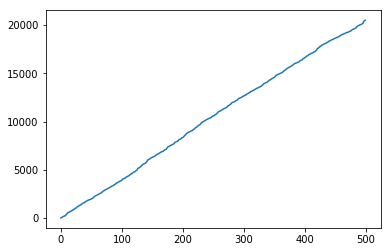

In [42]:
for i in range(10000):
    history.append(train_play(Game(), learner)[1])
    if len(history) % 100 == 0:
        print(len(history))
    if os.path.exists("002_reinforcement_example_v8_stop"):
        break
plt.plot(np.cumsum(history))

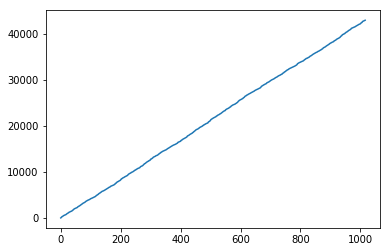

In [53]:
plt.plot(np.cumsum(history))

Epoch 1/10
29/29 [==============================] - 0s 62us/step - loss: 0.5156
Epoch 2/10
29/29 [==============================] - 0s 92us/step - loss: 0.4853
Epoch 3/10
29/29 [==============================] - 0s 86us/step - loss: 0.4772
Epoch 4/10
29/29 [==============================] - 0s 64us/step - loss: 0.4725
Epoch 5/10
29/29 [==============================] - 0s 64us/step - loss: 0.4691
Epoch 6/10
29/29 [==============================] - 0s 122us/step - loss: 0.4665
Epoch 7/10
29/29 [==============================] - 0s 118us/step - loss: 0.4644
Epoch 8/10
29/29 [==============================] - 0s 98us/step - loss: 0.4626
Epoch 9/10
29/29 [==============================] - 0s 105us/step - loss: 0.4611
Epoch 10/10
29/29 [==============================] - 0s 97us/step - loss: 0.4597
Epoch 1/10
25/25 [==============================] - 0s 107us/step - loss: 0.5817
Epoch 2/10
25/25 [==============================] - 0s 114us/step - loss: 0.4404
Epoch 3/10
25/25 [================

213/213 [==============================] - 0s 82us/step - loss: 0.1964
Epoch 1/10
312/312 [==============================] - 0s 92us/step - loss: 0.1625
Epoch 2/10
312/312 [==============================] - 0s 103us/step - loss: 0.1607
Epoch 3/10
312/312 [==============================] - 0s 88us/step - loss: 0.1583
Epoch 4/10
312/312 [==============================] - 0s 78us/step - loss: 0.1555
Epoch 5/10
312/312 [==============================] - 0s 75us/step - loss: 0.1522
Epoch 6/10
312/312 [==============================] - 0s 91us/step - loss: 0.1489
Epoch 7/10
312/312 [==============================] - 0s 98us/step - loss: 0.1463
Epoch 8/10
312/312 [==============================] - 0s 75us/step - loss: 0.1445
Epoch 9/10
312/312 [==============================] - 0s 101us/step - loss: 0.1427
Epoch 10/10
312/312 [==============================] - 0s 99us/step - loss: 0.1437
Epoch 1/10
228/228 [==============================] - 0s 139us/step - loss: 0.1743
Epoch 2/10
228/228 [===

372/372 [==============================] - 0s 97us/step - loss: 0.1883
Epoch 9/10
372/372 [==============================] - 0s 90us/step - loss: 0.1676
Epoch 10/10
372/372 [==============================] - 0s 80us/step - loss: 0.1081
Epoch 1/10
484/484 [==============================] - 0s 69us/step - loss: 0.1949
Epoch 2/10
484/484 [==============================] - 0s 96us/step - loss: 0.2129
Epoch 3/10
484/484 [==============================] - 0s 92us/step - loss: 0.1768
Epoch 4/10
484/484 [==============================] - 0s 72us/step - loss: 0.2130
Epoch 5/10
484/484 [==============================] - 0s 81us/step - loss: 0.2029
Epoch 6/10
484/484 [==============================] - 0s 70us/step - loss: 0.2286
Epoch 7/10
484/484 [==============================] - 0s 65us/step - loss: 0.2120
Epoch 8/10
484/484 [==============================] - 0s 75us/step - loss: 0.2321
Epoch 9/10
484/484 [==============================] - 0s 66us/step - loss: 0.1961
Epoch 10/10
484/484 [=====

595/595 [==============================] - 0s 67us/step - loss: 0.1169
Epoch 7/10
595/595 [==============================] - 0s 62us/step - loss: 0.1473
Epoch 8/10
595/595 [==============================] - 0s 76us/step - loss: 0.1289
Epoch 9/10
595/595 [==============================] - 0s 69us/step - loss: 0.1338
Epoch 10/10
595/595 [==============================] - 0s 63us/step - loss: 0.1332
Epoch 1/10
631/631 [==============================] - 0s 66us/step - loss: 0.3960
Epoch 2/10
631/631 [==============================] - 0s 59us/step - loss: 0.3755
Epoch 3/10
631/631 [==============================] - 0s 62us/step - loss: 0.3860
Epoch 4/10
631/631 [==============================] - 0s 72us/step - loss: 0.3784
Epoch 5/10
631/631 [==============================] - 0s 63us/step - loss: 0.3488
Epoch 6/10
631/631 [==============================] - 0s 64us/step - loss: 0.4416
Epoch 7/10
631/631 [==============================] - 0s 64us/step - loss: 0.3795
Epoch 8/10
631/631 [======

830/830 [==============================] - 0s 76us/step - loss: 0.1201
Epoch 5/10
830/830 [==============================] - 0s 76us/step - loss: 0.1310
Epoch 6/10
830/830 [==============================] - 0s 71us/step - loss: 0.0978
Epoch 7/10
830/830 [==============================] - 0s 64us/step - loss: 0.1170
Epoch 8/10
830/830 [==============================] - 0s 62us/step - loss: 0.1317
Epoch 9/10
830/830 [==============================] - 0s 64us/step - loss: 0.0974
Epoch 10/10
830/830 [==============================] - 0s 111us/step - loss: 0.1355
Epoch 1/10
785/785 [==============================] - 0s 60us/step - loss: 0.3031
Epoch 2/10
785/785 [==============================] - 0s 59us/step - loss: 0.2977
Epoch 3/10
785/785 [==============================] - 0s 59us/step - loss: 0.2915
Epoch 4/10
785/785 [==============================] - 0s 58us/step - loss: 0.2809
Epoch 5/10
785/785 [==============================] - 0s 63us/step - loss: 0.3306
Epoch 6/10
785/785 [=====

980/980 [==============================] - 0s 60us/step - loss: 0.1351
Epoch 3/10
980/980 [==============================] - 0s 60us/step - loss: 0.1290
Epoch 4/10
980/980 [==============================] - 0s 59us/step - loss: 0.1154
Epoch 5/10
980/980 [==============================] - 0s 57us/step - loss: 0.1112
Epoch 6/10
980/980 [==============================] - 0s 58us/step - loss: 0.1156
Epoch 7/10
980/980 [==============================] - 0s 66us/step - loss: 0.1168
Epoch 8/10
980/980 [==============================] - 0s 52us/step - loss: 0.1071
Epoch 9/10
980/980 [==============================] - 0s 60us/step - loss: 0.1381
Epoch 10/10
980/980 [==============================] - 0s 80us/step - loss: 0.1082
Epoch 1/10
1001/1001 [==============================] - 0s 53us/step - loss: 0.2788
Epoch 2/10
1001/1001 [==============================] - 0s 57us/step - loss: 0.2730
Epoch 3/10
1001/1001 [==============================] - 0s 63us/step - loss: 0.3602
Epoch 4/10
1001/1001

1197/1197 [==============================] - 0s 85us/step - loss: 0.1880
Epoch 7/10
1197/1197 [==============================] - 0s 67us/step - loss: 0.2023
Epoch 8/10
1197/1197 [==============================] - 0s 57us/step - loss: 0.1767
Epoch 9/10
1197/1197 [==============================] - 0s 60us/step - loss: 0.1905
Epoch 10/10
1197/1197 [==============================] - 0s 60us/step - loss: 0.1717
Epoch 1/10
1210/1210 [==============================] - 0s 56us/step - loss: 0.1556
Epoch 2/10
1210/1210 [==============================] - 0s 59us/step - loss: 0.1504
Epoch 3/10
1210/1210 [==============================] - 0s 64us/step - loss: 0.1443
Epoch 4/10
1210/1210 [==============================] - 0s 61us/step - loss: 0.1617
Epoch 5/10
1210/1210 [==============================] - 0s 57us/step - loss: 0.1478
Epoch 6/10
1210/1210 [==============================] - 0s 53us/step - loss: 0.1400
Epoch 7/10
1210/1210 [==============================] - 0s 57us/step - loss: 0.1598
Ep

1372/1372 [==============================] - 0s 64us/step - loss: 0.1624
Epoch 1/10
1424/1424 [==============================] - 0s 52us/step - loss: 0.1309
Epoch 2/10
1424/1424 [==============================] - 0s 59us/step - loss: 0.1148
Epoch 3/10
1424/1424 [==============================] - 0s 63us/step - loss: 0.1194
Epoch 4/10
1424/1424 [==============================] - 0s 56us/step - loss: 0.1106
Epoch 5/10
1424/1424 [==============================] - 0s 62us/step - loss: 0.1341
Epoch 6/10
1424/1424 [==============================] - 0s 54us/step - loss: 0.1049
Epoch 7/10
1424/1424 [==============================] - 0s 62us/step - loss: 0.1292
Epoch 8/10
1424/1424 [==============================] - 0s 58us/step - loss: 0.1393
Epoch 9/10
1424/1424 [==============================] - 0s 55us/step - loss: 0.0953
Epoch 10/10
1424/1424 [==============================] - 0s 64us/step - loss: 0.1095
Epoch 1/10
1381/1381 [==============================] - 0s 66us/step - loss: 0.1676
Ep

1521/1521 [==============================] - 0s 55us/step - loss: 0.1249
Epoch 5/10
1521/1521 [==============================] - 0s 57us/step - loss: 0.1319
Epoch 6/10
1521/1521 [==============================] - 0s 57us/step - loss: 0.1260
Epoch 7/10
1521/1521 [==============================] - 0s 55us/step - loss: 0.1144
Epoch 8/10
1521/1521 [==============================] - 0s 55us/step - loss: 0.1212
Epoch 9/10
1521/1521 [==============================] - 0s 61us/step - loss: 0.1257
Epoch 10/10
1521/1521 [==============================] - 0s 79us/step - loss: 0.1196
Epoch 1/10
1612/1612 [==============================] - 0s 60us/step - loss: 0.1329
Epoch 2/10
1612/1612 [==============================] - 0s 56us/step - loss: 0.1221
Epoch 3/10
1612/1612 [==============================] - 0s 52us/step - loss: 0.1417
Epoch 4/10
1612/1612 [==============================] - 0s 60us/step - loss: 0.1394
Epoch 5/10
1612/1612 [==============================] - 0s 64us/step - loss: 0.1351
Ep

1812/1812 [==============================] - 0s 58us/step - loss: 0.1133
Epoch 9/10
1812/1812 [==============================] - 0s 57us/step - loss: 0.1040
Epoch 10/10
1812/1812 [==============================] - 0s 59us/step - loss: 0.1253
Epoch 1/10
1689/1689 [==============================] - 0s 78us/step - loss: 0.1350
Epoch 2/10
1689/1689 [==============================] - 0s 63us/step - loss: 0.1249
Epoch 3/10
1689/1689 [==============================] - 0s 56us/step - loss: 0.1254
Epoch 4/10
1689/1689 [==============================] - 0s 59us/step - loss: 0.1162
Epoch 5/10
1689/1689 [==============================] - 0s 56us/step - loss: 0.1246
Epoch 6/10
1689/1689 [==============================] - 0s 57us/step - loss: 0.1177
Epoch 7/10
1689/1689 [==============================] - 0s 60us/step - loss: 0.1234
Epoch 8/10
1689/1689 [==============================] - 0s 52us/step - loss: 0.1167
Epoch 9/10
1689/1689 [==============================] - 0s 58us/step - loss: 0.1305
Ep

2085/2085 [==============================] - 0s 61us/step - loss: 0.1079
Epoch 3/10
2085/2085 [==============================] - 0s 60us/step - loss: 0.1118
Epoch 4/10
2085/2085 [==============================] - 0s 54us/step - loss: 0.1065
Epoch 5/10
2085/2085 [==============================] - 0s 59us/step - loss: 0.1057
Epoch 6/10
2085/2085 [==============================] - 0s 56us/step - loss: 0.1286
Epoch 7/10
2085/2085 [==============================] - 0s 54us/step - loss: 0.1242
Epoch 8/10
2085/2085 [==============================] - 0s 60us/step - loss: 0.1110
Epoch 9/10
2085/2085 [==============================] - 0s 69us/step - loss: 0.1221
Epoch 10/10
2085/2085 [==============================] - 0s 55us/step - loss: 0.1027
Epoch 1/10
1921/1921 [==============================] - 0s 59us/step - loss: 0.1318
Epoch 2/10
1921/1921 [==============================] - 0s 60us/step - loss: 0.1299
Epoch 3/10
1921/1921 [==============================] - 0s 54us/step - loss: 0.1328
Ep

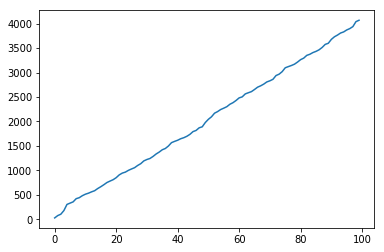

In [21]:
for i in range(100):
    history.append(train_play(Game(), learner)[1])
plt.plot(np.cumsum(history))

In [51]:
np.mean(history)

41.017197365601405

In [172]:
len(history)

1184

In [107]:
# import pickle
# with open('002_reinforcement_example_v2_learner.pickle', 'wb') as f:
#     pickle.dump({
#         'histories': learner.histories,
#         'value_model': [
#             {
#                 'config': model.get_config(),
#                 'weights': model.get_weights()
#             }
#             for model in learner.value_model
#         ]
#     }, f)

AttributeError: 'ScaledModel' object has no attribute 'get_config'

In [169]:
import pickle
with open('002_reinforcement_example_v5_learner_v3.pickle', 'wb') as f:
    pickle.dump(dict([(foo, learner.__dict__[foo]) for foo in learner.__dict__
                      if foo != "value_model" and foo != 'policy'] +
                     [("value_model", [{
                         "xscale": model.xscale,
                         "yscale": model.yscale,
                         "config": model.model.get_config(),
                         "weights": model.model.get_weights()
                     } for model in learner.value_model])]), f)

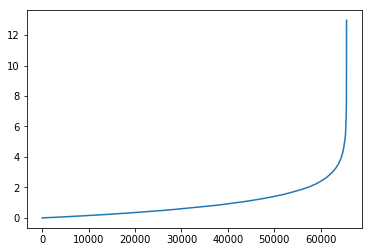

In [179]:
plt.plot(np.sort(learner.rewards))

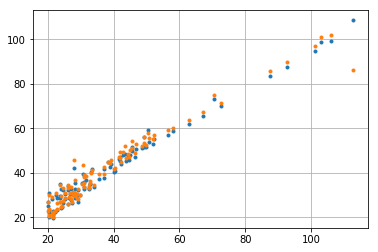

In [50]:
foo = np.zeros((100, 4))
for i in range(foo.shape[0]):
    foo[i, :4] = Game().get_state()
fooy0 = learner.value_model[0].predict(foo).reshape(-1)
fooy1 = learner.value_model[1].predict(foo).reshape(-1)
plt.plot(foo[:, 3], fooy0, '.')
plt.plot(foo[:, 3], fooy1, '.')
plt.grid()

In [56]:
np.min(learner.rewards)

4.490789154299005e-06

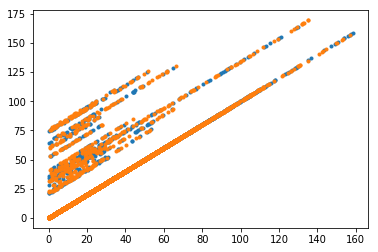

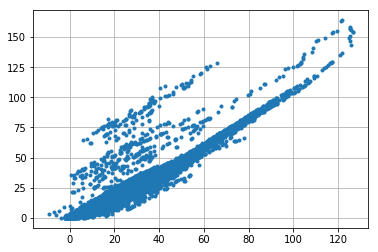

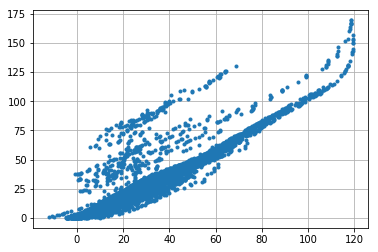

In [49]:
        cumrewards = np.empty(len(learner.states))
        for start, end in learner.ranges:
            cumrewards[start:end] = np.cumsum(learner.rewards[start:end])
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = cumrewards[learner.actinds[action]]
            plt.plot(X[:, 3], Y, '.')
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = cumrewards[learner.actinds[action]]
            plt.figure()
            plt.plot(learner.value_model[action].predict(X), Y, '.')
            #plt.title('Prediction vs response, RMS = {}'.format(learner.value_model[action].evaluate(X[inds], Y[inds])))
            plt.grid(True)

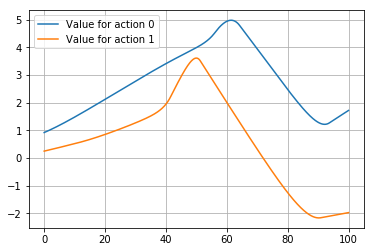

In [48]:
foo_heights = np.linspace(0, 100, 1000)
foo_states = np.empty((len(foo_heights), 4))
foo_states[:, 0] = foo_heights
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = 1
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_heights, foo_v, label="Value for action {}".format(action))
plt.grid(True)
plt.legend()

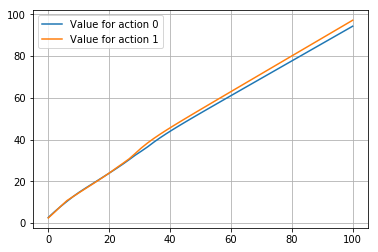

In [47]:
foo_dists = np.linspace(0, 100)
foo_states = np.empty((len(foo_dists), 4))
foo_states[:, 0] = 50
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = foo_dists
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_dists, foo_v, label="Value for action {}".format(action))
plt.legend()
plt.grid(True)

In [195]:
learner.policy.scale

1.1571137082807434

In [61]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += learner.cumrewards[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

AttributeError: 'TDLearner' object has no attribute 'cumrewards'

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


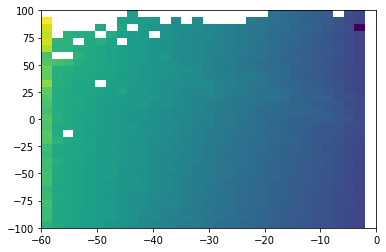

In [46]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
predictions = np.mean([model.predict(learner.states).reshape(-1) for model in learner.value_model], axis=0)
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += predictions[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

In [44]:
def mean_heatmap(x, y, z, xbins, ybins):
    xi = np.searchsorted(xbins, x)
    yi = np.searchsorted(ybins, y)
    totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
    counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
    for i in range(len(learner.states)):
        totals[xi[i], yi[i]] += z[i]
        counts[xi[i], yi[i]] += 1
    plt.imshow((totals / counts).T,
               origin = 'lower',
               aspect='auto',
               extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))
    plt.colorbar()
    plt.contour(np.linspace(xbins[0], xbins[-1], len(xbins) + 1),
                np.linspace(ybins[0], ybins[-1], len(ybins) + 1),
                (totals / counts).T,
                colors='k')


/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


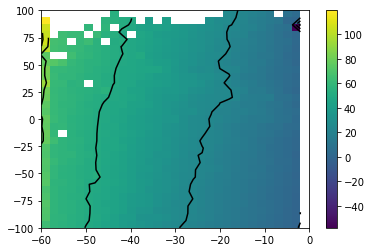

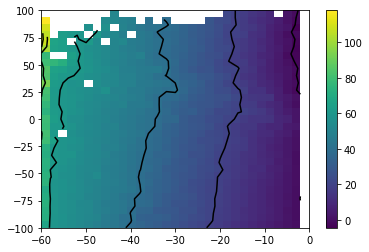

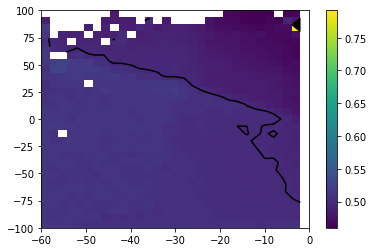

In [45]:
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
for action in range(learner.num_actions):
    predictions = learner.value_model[action].predict(learner.states).reshape(-1)
    plt.figure()
    mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

predictions = logodds_to_probs(learner.policy.predict(learner.states))[:, 1]
plt.figure()
mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

In [64]:
np.min(predictions), np.max(predictions)

(161.00038, 161.0004)

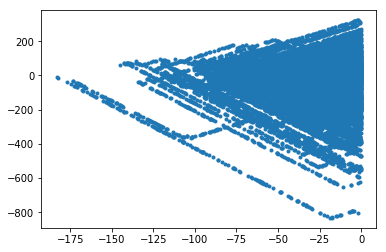

In [178]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
plt.plot(-learner.states[:, 3], dy, '.')
plt.ylabel("Hieght relative to the hole")
plt.xlabel("Distance to the wall")

#### Test the ability of the neural network to learn...

In [ ]:
model = make_model(6, 1)

In [ ]:
data = np.random.rand(6000).reshape((1000, 6)) * 3

In [ ]:
for row in data:
    model.train_on_batch(row[np.newaxis, :], row[[-1]])

In [ ]:
foo = np.random.rand(600).reshape((100, 6)) * 3
fooy = model.predict(foo)
plt.plot(foo[:, -1], fooy.reshape(-1), '.')
plt.grid(True)